In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as C
from scipy.interpolate import CubicSpline
from scipy import integrate
import pandas as pd
from scipy.integrate import odeint

In [ ]:
############### copia de seguirdad chafa


    # Área de quemado
    V0 = m_p[i]/(rho*1000) # m^3 Volumen con densidad experiemental del grano
    Lg0 = V0*10**9/(np.pi/4*((Dc - 2*In)**2-Dp**2)) # mm  Longitud del grano con densidad experimental
    Vc =Ac*(Lg0*1.01)*10**-9

    #Vc = (V0)/(1-ApAt*At*4/(np.pi*(Dc - 2*In)**2)) # m^3 Volumen disponible de la camara
    v0 = Vc - V0 # m^3 volumen libre de la cámara
    #print(f'v0={v0}')

    print(f'v0={v0*10**6}', f'Va={Vc*10**6}') # cm^^3
    
    Lc = Vc*10**9/Ac # mm Longitud de la cámara
    Lg0 = V0*10**9/(np.pi/4*((Dc - 2*In)**2-Dp**2)) # mm  Longitud del grano con densidad experimental


    # %%

    A_t = At*10**-6 # Área de la garganta en m^3
    A_e = Ae*10**-6 # Área de la salida en m^3
    P_a = 0.101325 # Mpa Presión atmosferica
    
    fase2_activa = False
    tb = 0

    def Ec_Presion(t, CI, p):
        global fase2_activa, tb
        a, n, Dc, Dp, Lg0, Bs, In, rho_p, k, M, To, At, N = p
        Po, rho_0, v0, m, mg, X = CI
        
        r = a * (Po + 101325)**n
        print(X*1e3, r*t*1e3, f'x-rt: [{np.abs(X-r*t)*1e3}]', t)
        if np.abs(X-r*t)*1e3 < 1e-2:
            print('La regresión lineal x=rt, es aproximadamente igual a dXdt')
        else :
            raise ValueError('La regresión lineal x=rt, es diferente a dXdt')  
        if r * t <= (Dc - Dp) / 2 and not fase2_activa:
            x = r * t
        else:
            if r * t >= (Dc - Dp) / 2 and not fase2_activa:
                    tb = t
                    if r * t <= (Dc - Dp) / 2:
                        raise ValueError(f"La regresión lineal es menor que{(Dc-Dp)/2}.")
            else:
                next
            fase2_activa = True
            x = 0
        Ab = Ab_(Dc, In, Dp, Lg0, x, N, Bs)
        #print(f'x={x*10**3}', f'r={r*10**3}')
        #print(Ab*10**3, x*10**3, Po, rho_0, v0, t)


        dXdt = r # en caso de funcionar cambiar la x chiquita
        dmdt = At * (Po + 101325) * np.sqrt((1 / (cte.R / M * To)) * k * (2 / (k + 1)) ** ((k + 1) / (k - 1)))
        dmgdt = Ab * r * rho_p
        dP0dt = (cte.R * To / (M * v0)) * (dmgdt - Ab * r * rho_0 - dmdt)
        dv0dt = Ab * r
        drho_0dt = 1 / (cte.R / M * To) * dP0dt

        return [dP0dt, drho_0dt, dv0dt, dmdt, dmgdt, dXdt]

    def event_pressure_zero(t, CI, p):
        Po, rho_0, v0, m, mg, X = CI
        return Po

    event_pressure_zero.terminal = True
    event_pressure_zero.direction = -1


    CI_P = [0, 0, v0, 0, 0, 0]

    p_P = [a * 10**(-3-6*n), n, Dc* 10**-3, Dp * 10**-3, Lg0*10**-3, Bs, In, rho*1000, k, M, To, A_t, N]

    #print(f'parametros {p_P}')

    t_span = (0, 10)
    t_eval = np.linspace(0, 10, Datos)
    sol = solve_ivp(Ec_Presion, t_span, CI_P, args=(p_P,), events=event_pressure_zero, t_eval=t_eval)

    Presion_camara = sol.y[0]/1e6 # Mpa
    t_thrust = sol.t
    #print(f'Po={Presion_camara}')
    #print(f't={sol.t}')

    r = a*(Presion_camara)**n # mm/s
    X_num = sol.y[5]*1e3
    X = r*t_thrust            # mm

In [19]:
import math
import numpy as np

def atmospheric_pressure(h):
    P0 = 101325  # Presión a nivel del mar en Pascales
    T0 = 288.15  # Temperatura a nivel del mar en Kelvin
    g = 9.80665  # Aceleración debido a la gravedad en m/s^2
    M = 0.0289644  # Masa molar del aire en kg/mol
    R = 8.3144598  # Constante de los gases ideales en J/(mol·K)

    # Capas de la atmósfera con sus alturas y parámetros
    layers = [
        (11000, 288.15, 101325, -0.0065),
        (20000, 216.65, 22632.1, 0),
        (32000, 216.65, 5474.89, 0.001),
        (47000, 228.65, 868.02, 0.0028),
        (51000, 270.65, 110.91, 0),
        (71000, 270.65, 66.94, -0.0028),
        (84852, 214.65, 3.956, -0.0028),
        (95000, 186.87, 0.3734, 0),
        (105000, 186.87, 0.0971, 0.002),
        (110000, 190.65, 0.0135, 0)
    ]
    
    # Seleccionar la capa correspondiente
    for h_b, T_b, P_b, L in layers:
        if h <= h_b:
            break
    
    if L == 0:
        T = T_b
        P = P_b * np.exp(-g * M * (h - (h_b if h_b < 11000 else layers[layers.index((h_b, T_b, P_b, L)) - 1][0])) / (R * T))
    else:
        T = T_b + L * (h - (h_b if h_b < 11000 else layers[layers.index((h_b, T_b, P_b, L)) - 1][0]))
        P = P_b * (T / T_b) ** (-g * M / (R * L))
    
    return P, T

# Ejemplo para 1000 y 150000 metros
altitude1 = 0
pressure1, temperature1 = atmospheric_pressure(altitude1)
print(f"Presión a {altitude1} metros: {pressure1:.2f} Pa, Temperatura: {temperature1:.2f} K")

altitude2 = 50000
pressure2, temperature2 = atmospheric_pressure(altitude2)
print(f"Presión a {altitude2} metros: {pressure2:.2f} Pa, Temperatura: {temperature2:.2f} K")


Presión a 0 metros: 71289437.21 Pa, Temperatura: 1003.15 K
Presión a 50000 metros: 75.95 Pa, Temperatura: 270.65 K


In [31]:
def atmospheric_pressure(h):
    P0 = 101325  # Presión a nivel del mar en Pascales
    T0 = 288.15  # Temperatura a nivel del mar en Kelvin
    g = 9.80665  # Aceleración debido a la gravedad en m/s^2
    M = 0.0289644  # Masa molar del aire en kg/mol
    R = 8.3144598  # Constante de los gases ideales en J/(mol·K)

    # Capas de la atmósfera con sus alturas y parámetros
    layers = [
        (0, 288.15, 101325, -0.0065),
        (11000, 216.65, 22632.1, 0),
        (20000, 216.65, 5474.89, 0.001),
        (32000, 228.65, 868.02, 0.0028),
        (47000, 270.65, 110.91, 0),
        (51000, 270.65, 66.94, -0.0028),
        (71000, 214.65, 3.956, -0.0028),
        (84852, 186.87, 0.3734, 0),
        (95000, 186.87, 0.0971, 0.002),
        (105000, 190.65, 0.0135, 0)
    ]
    
    # Seleccionar la capa correspondiente
    for i, (h_b, T_b, P_b, L) in enumerate(layers):
        if h < h_b:
            h_b, T_b, P_b, L = layers[i - 1]
            break
    else:
        h_b, T_b, P_b, L = layers[-1]
    
    if L == 0:
        T = T_b
        P = P_b * np.exp(-g * M * (h - h_b) / (R * T))
    else:
        T = T_b + L * (h - h_b)
        P = P_b * (T / T_b) ** (-g * M / (R * L))
    
    return P, T

# Ejemplo para 0 y 50000 metros
altitude1 = 0
pressure1, temperature1 = atmospheric_pressure(altitude1)
print(f"Presión a {altitude1} metros: {pressure1:.2f} Pa, Temperatura: {temperature1:.2f} K")

altitude2 = 50000
pressure2, temperature2 = atmospheric_pressure(altitude2)
print(f"Presión a {altitude2} metros: {pressure2:.2f} Pa, Temperatura: {temperature2:.2f} K")

print(atmospheric_pressure(0)[1])




Presión a 0 metros: 101325.00 Pa, Temperatura: 288.15 K
Presión a 50000 metros: 75.95 Pa, Temperatura: 270.65 K
288.15


In [40]:
def Hola(a):
    A=a
    return A*[1,2],A*[3,4]

p, j = Hola(1)

k = [2,8,9]
l = [10,12, 13]

print(np.array(k)**2)





[ 4 64 81]


In [9]:
import numpy as np

def Cf_(Pe, P0, Pa, At, Ae, k, N_throat, N_div, N_noz, N_skin):
    # Convertir a numpy array solo si la entrada es una lista
    if isinstance(Pe, list):
        Pe = np.array(Pe)
    if isinstance(P0, list):
        P0 = np.array(P0)
    if isinstance(Pa, list):
        Pa = np.array(Pa)
    if isinstance(At, list):
        At = np.array(Pa)

    term1 = (2 * k**2 / (k - 1) * (2 / (k + 1))**((k + 1) / (k - 1)))
    term2 = (Pe / P0)**((k - 1) / k)
    term2 = np.minimum(term2, 1)  # Asegurar que term2 sea siempre <= 1 para evitar raíces cuadradas de negativos
    term3 = np.sqrt(term1 * (1 - term2))
    term4 = (Pe - Pa) * Ae / (P0 * At)

    Cf = term3 + term4

    # Condición para Pe < Pa
    if isinstance(Pe, np.ndarray):
        condition = Pe < Pa
        Cf[condition] = N_throat * N_div * N_noz * N_skin
    else:
        if Pe < Pa:
            Cf = N_throat * N_div * N_noz * N_skin

    return Cf

# Ejemplo de uso con listas
Pe_list = np.array([500, 600, 700, 800]
P0_list = [1000, 1000, 1000, 1000]
Pa_list = [650, 650, 650, 650]
At = 1
Ae = 10
k = 1.4

N_throat = 0.9
N_div = 0.8
N_noz = 0.95
N_skin = 0.97

result_list = Cf_(Pe_list, P0_list, Pa_list, At, Ae, k, N_throat, N_div, N_noz, N_skin)
result_single = Cf_(14.7, 1000, 14.69, At, Ae, k, N_throat, N_div, N_noz, N_skin)

print("Resultado con listas:", result_list)
print("Resultado con un solo valor:", result_single)



Resultado con listas: [0.66348    0.66348    1.06389872 1.95023793]
Resultado con un solo valor: 1.516374181665367


In [10]:
import numpy as np
from scipy.optimize import fsolve

def eRatioFromPRatio(k, pRatio):
    return (((k + 1) / 2) ** (1 / (k - 1))) * (pRatio ** (1 / k)) * ((((k + 1) / (k - 1)) * (1 - (pRatio ** ((k - 1) / k)))) ** 0.5)

def calcExpansion(Ae_At):
    return Ae_At

def getExitPressure(k, inputPressure, Ae_At):
    expansion_ratio = calcExpansion(Ae_At)
    return fsolve(lambda x: (1 / expansion_ratio) - eRatioFromPRatio(k, x / inputPressure), 0)[0]

# Datos proporcionados
inputPressure_psi = 64.22
inputPressure_pa = inputPressure_psi * 6894.76  # Convertir psi a Pa
Ae_At = 5.286
k = 1.4

# Calcular la presión de salida
exitPressure = getExitPressure(k, inputPressure_pa, Ae_At)
exitPressure_psi = exitPressure / 6894.76  # Convertir Pa a psi
print("Presión de salida en psi:", exitPressure_psi)


Presión de salida en psi: 1.2367109538515708


In [25]:
import numpy as np
from scipy.optimize import fsolve

def eRatioFromPRatio(k, pRatio):
    return (((k + 1) / 2) ** (1 / (k - 1))) * (pRatio ** (1 / k)) * ((((k + 1) / (k - 1)) * (1 - (pRatio ** ((k - 1) / k)))) ** 0.5)

def calcExpansion(Ae_At):
    return Ae_At

def getExitPressure(k, inputPressure, Ae_At):
    expansion_ratio = calcExpansion(Ae_At)
    return fsolve(lambda x: (1 / expansion_ratio) - eRatioFromPRatio(k, x / inputPressure), 0)[0]

def getThrustCoefficient(chamberPres, exitPres, ambPres, gamma, Ae_At):
    throatArea = 1.0  # Assuming throat area At is 1 unit for simplification
    exitArea = throatArea * Ae_At

    term1 = (2 * (gamma ** 2)) / (gamma - 1)
    term2 = (2 / (gamma + 1)) ** ((gamma + 1) / (gamma - 1))
    term3 = 1 - ((exitPres / chamberPres) ** ((gamma - 1) / gamma))

    momentumThrust = (term1 * term2 * term3) ** 0.5
    pressureThrust = ((exitPres - ambPres) * Ae_At) / ( chamberPres)

    return momentumThrust + pressureThrust


# Datos proporcionados
inputPressure_psi = 64.2
inputPressure_pa = inputPressure_psi * 6894.76  # Convertir psi a Pa
Ae_At = 5.286
gamma = 1.214

exitPressure = getExitPressure(gamma, inputPressure_psi, Ae_At)
exitPres = exitPressure / 6894.76  # Convertir psi a Pa
ambPres = 14.7 * 6894.76  # Convertir psi a Pa
chamberPres = inputPressure_pa

# Calcular la presión de salida
exitPressure = getExitPressure(gamma, chamberPres, Ae_At)
exitPressure_psi = exitPressure / 6894.76  # Convertir Pa a psi
print("Presión de salida en psi:", exitPressure_psi)

# Calcular el coeficiente de empuje
thrustCoefficient = getThrustCoefficient(chamberPres, exitPres, ambPres, gamma, Ae_At)

print(getThrustCoefficient(64.2, 1.84+14.7, 14.7, gamma, Ae_At)*.85)
print(chamberPres/6894.76, exitPres/6894.76, ambPres/6894.76, gamma, Ae_At)
print("Coeficiente de empuje:", thrustCoefficient)


Presión de salida en psi: 1.8403945637514767
0.9885745657340803
64.2 3.8714409096772945e-08 14.7 1.214 5.286
Coeficiente de empuje: 0.9570930949142875


## CF

In [18]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt


CF = Cf_()

La solución para k/k_0 es: 2770082998.853771
k = 213296.3909117404


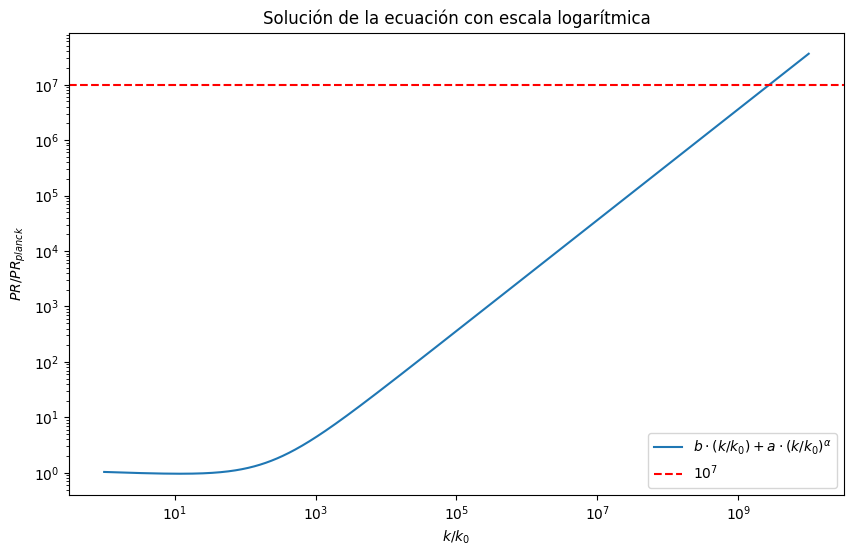

In [19]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Definir la función a resolver
def equation(k_k0, a, b, alpha, target):
    return b * k_k0 + a * k_k0**alpha - target

# Valores dados
a = 1.035
b = 0.00361
alpha = -0.0468
target = 10**7
k_0 = 7.7*1e-5

# Suposición inicial para k/k_0
initial_guess = 1e9

# Resolver la ecuación
k_k0_solution = fsolve(equation, initial_guess, args=(a, b, alpha, target))[0]
k= k_k0_solution*k_0
print("La solución para k/k_0 es:", k_k0_solution)
print(f'k = {k}')

# Generar valores para la gráfica
def equation_to_plot(k_k0, a, b, alpha):
    return b * k_k0 + a * k_k0**alpha

k_k0_values = np.logspace(0, 10, 1000)
equation_values = equation_to_plot(k_k0_values, a, b, alpha)

# Crear la gráfica con ejes en escala logarítmica
plt.figure(figsize=(10, 6))
plt.plot(k_k0_values, equation_values, label=r'$b \cdot (k/k_0) + a \cdot (k/k_0)^\alpha$')
plt.axhline(y=target, color='r', linestyle='--', label=r'$10^7$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k/k_0$')
plt.ylabel(r'$PR/PR_{planck}$')
plt.title('Solución de la ecuación con escala logarítmica')
plt.legend()
#plt.grid(True, which="both", ls="--")
plt.show()




In [27]:
import numpy as np

def calcular_densidad(h):
    R = 287.05  # J/(kg·K)
    g = 9.80665  # m/s^2

    # Valores iniciales
    T0 = 288.15  # K
    P0 = 101325  # Pa
    L0 = -0.0065  # K/m
    T11 = 216.65  # K
    P11 = 22632.1  # Pa
    T20 = 216.65  # K
    P20 = 5474.89  # Pa
    T32 = 228.65  # K
    P32 = 868.019  # Pa
    T47 = 270.65  # K
    P47 = 110.906  # Pa
    T51 = 270.65  # K
    P51 = 66.939  # Pa
    L2 = 0.001  # K/m
    L3 = 0.0028  # K/m
    L4 = 0.002  # K/m

    if h < 0 or h > 200000:
        raise ValueError("Altura fuera del rango válido (0-200 km).")

    if h <= 11000:
        T = T0 + L0 * h
        P = P0 * (1 + (L0 * h / T0)) ** (-g / (L0 * R))
    elif h <= 20000:
        T = T11
        P = P11 * np.exp(-g * (h - 11000) / (R * T))
    elif h <= 32000:
        T = T20 + L2 * (h - 20000)
        P = P20 * (1 + L2 * (h - 20000) / T20) ** (-g / (L2 * R))
    elif h <= 47000:
        T = T32 + L3 * (h - 32000)
        P = P32 * (1 + L3 * (h - 32000) / T32) ** (-g / (L3 * R))
    elif h <= 51000:
        T = T47
        P = P47 * np.exp(-g * (h - 47000) / (R * T))
    elif h <= 200000:
        T = T51 + L4 * (h - 51000)
        P = P51 * (1 + L4 * (h - 51000) / T51) ** (-g / (L4 * R))
    
    rho = P
    return rho

# Ejemplo de uso
alturas = [0, 3000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 80000, 100000, 150000, 200000]
densidades = [calcular_densidad(h) for h in alturas]

for h, rho in zip(alturas, densidades):
    print(f"Altura: {h/1000:.1f} km, Densidad: {rho:.4e} kg/m^3")


Altura: 0.0 km, Densidad: 1.0132e+05 kg/m^3
Altura: 3.0 km, Densidad: 7.0108e+04 kg/m^3
Altura: 10.0 km, Densidad: 2.6436e+04 kg/m^3
Altura: 15.0 km, Densidad: 1.2045e+04 kg/m^3
Altura: 20.0 km, Densidad: 5.4748e+03 kg/m^3
Altura: 30.0 km, Densidad: 1.1718e+03 kg/m^3
Altura: 40.0 km, Densidad: 2.7752e+02 kg/m^3
Altura: 50.0 km, Densidad: 7.5944e+01 kg/m^3
Altura: 60.0 km, Densidad: 2.2285e+01 kg/m^3
Altura: 80.0 km, Densidad: 2.4280e+00 kg/m^3
Altura: 100.0 km, Densidad: 3.4135e-01 kg/m^3
Altura: 150.0 km, Densidad: 5.6583e-03 kg/m^3
Altura: 200.0 km, Densidad: 2.0791e-04 kg/m^3


In [6]:
T = False
i=1
while i<5 and not T == True:
    i += 2
    print(i)
else:
    T= True
    print('hola mundo', T)

3
5
hola mundo True


# Factores de seguridad

In [8]:
N = 8
MEOP = 900
D_i_carcasa = 2.125
D_o_carcasa = 2.25
d_i_menor = .1018*2 #0.1959 # .1018*2
d_o_mayor = .25
E = 2*d_o_mayor
E_min = E-d_o_mayor/2

## carcasa aluminio

### propiedades del aluminio 6063 T5 https://asm.matweb.com/search/SpecificMaterial.asp?bassnum=MA6063T5, https://www.matweb.com/search/DataSheet.aspx?MatGUID=79875d1b30c94af39029470988004fb6&ckck=1
## propiedade sdel aluminio 6061 T6 https://www.matweb.com/search/datasheet.aspx?MatGUID=b8d536e0b9b54bd7b69e4124d8f1d20a

t = 0.065
UTS = 170*1e3 # psi 
RS = 30*1e3 #  17 resistencia el corte (shear strength)
YTS = 38*1e3 # 21 para 6063 Resistencia a la tracción (Yield Tensile Strength)
BYS = 56*1e3  # 21 Resistencia al apoyo (Bearing Yield Strength)

F_tornillo = np.pi/4*D_i_carcasa**2*MEOP/N


Sig_cort_tornillo = F_tornillo/(np.pi/4*d_i_menor**2)
FS_cort_tornillo = 0.75*UTS/Sig_cort_tornillo

Sig_desgarramiento = F_tornillo/(E_min*2*t)
FS_desgarramiento = RS/Sig_desgarramiento

Sig_traccion = F_tornillo*N/(((D_o_carcasa-t)*np.pi-N*d_o_mayor)*t)
FS_traccion = YTS/Sig_traccion

Sig_apoyo = F_tornillo/(d_o_mayor*t)
FS_apoyo = BYS/Sig_apoyo

r_shear =16.16/25.4 
L_shear = 5/25.4

Sig_bulk = F_tornillo*N/(2*np.pi*r_shear*L_shear)
RS_acero304 = 55984.6 #psi
FS_bulk = RS_acero304/Sig_bulk

print(f'FS corte tornillo {FS_cort_tornillo}', f'FS desgarramiento: {FS_desgarramiento}')
print(f'FS tracción {FS_traccion}', f'FS apoyo {FS_apoyo}')
print(f'FS headbulk {FS_bulk}', f'FS tobera {0}')

FS corte tornillo 10.403880156862746 FS desgarramiento: 3.665520073424413
FS tracción 3.7642129393945827 FS apoyo 2.2807680456863015
FS headbulk 13.802002950595675 FS tobera 0


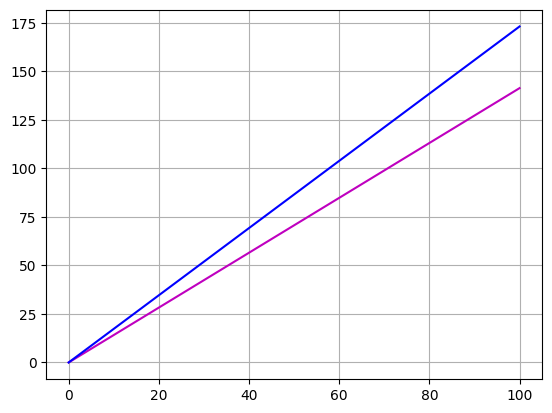

In [3]:
Dt = np.linspace(0,100, 200)
y = np.linspace(0,100, 200)
ApAt1=2
ApAt2=3
Dp1=np.sqrt(ApAt1)*Dt
Dp2=np.sqrt(ApAt2)*Dt

plt.plot(Dt, Dp1,'-m')
plt.plot(Dt, Dp2,'-b')
plt.grid()
plt.show()


In [9]:
k =[1,2,3,4,5,6,7]
Jo=[0]
for n in range(len(k)):
    Jo.append(n+2)
    print(n, Jo[n])

0 0
1 2
2 3
3 4
4 5
5 6
6 7


[4. 4. 4. 4. 4. 4.]


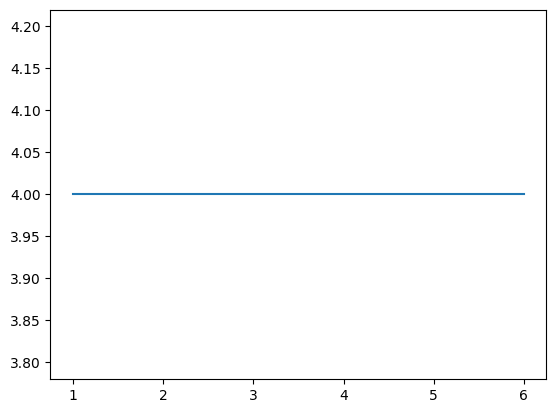

In [3]:
A = [1,2,3,4,5,6]

print(np.ones(len(A))*4)

plt.plot(A,np.ones(len(A))*4 )

In [4]:
sol = np.array([1,4,6,7,23,14,5])

ind = np.where(sol == max(sol))
print(ind)

(array([4], dtype=int64),)


In [3]:
def mach(P, Po, k):
    a = (k-1)/k
    return np.sqrt((2/(k-1))*((Po/P)**a - 1))

def RatArea(M1, M2, k):
    a=(k+1)/(2*(k-1))
    b=(k-1)/2
    return (M2/M1)*(((1+b*(M1**2))/(1+b*(M2**2)))**a) # A1/A2

def A1A2(Po,P,k):
    a = (k-1)/k
    b = (((k+1)/2)**(1/(k-1)))*((P/Po)**(1/k))
    c = np.sqrt((k+1)/(k-1)*(1-(P/Po)**a))
    return b*c

def Cf_(Pe, P0, Pa, At, Ae, k):
    term1 = (2 * k**2 / (k - 1) * (2 / (k + 1))**((k + 1) / (k - 1)))
    term2 = (Pe / P0)**((k - 1) / k)
    # Asegurar que term2 sea siempre <= 1 para evitar raíces cuadradas de negativos
    if term2 > 1:
        term2 = 1
    term3 = np.sqrt(max(term1 * (1 - term2), 0))  # Asegurar que el argumento de sqrt sea no negativo
    term4 = (Pe - Pa) * Ae / (P0 * At)
    if P0 == 0 or Ae == 0:
        Cf = 1
    else:
        Cf = term3 + term4
    return Cf

def thrust(Cf,At,P0):
    return At*P0*Cf*6894.757*10**(-6)

def Isp_(k, Pe, Po, To, M):
    R=C.R
    a=(k-1)/k
    Isp=(1/C.g)*np.sqrt(((2*To*(R/(M*a))))*(1-(Pe/Po)**a))
    return Isp

def diametro(A):
    return np.sqrt((4*A)/C.pi)

def altura(m, mp, F, Isp, angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    
    # Fase 1
    t1=(Isp)*mp*C.g/F
    h1=1/2*ay*t1**2
    if h1>3000 :
        print("La fase 1 pasa de 3000 metros")
    
    V_y1=ay*t1
    
    # Fase 2
    t2=V_y1/C.g

    h=(ay*t1**2/2)*(1+ay/C.g)
    return h

def masa_propelente(F, Isp, m, h,angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    mp=(F/Isp)*np.sqrt(2*h/(C.g*ay)*(1/(C.g+ay)))
    return mp

def ex_vel(R, To, k, M):
    a = (k+1)/(k-1)
    c = np.sqrt(R/M*To/(k*(2/(k+1))**a))
    return c

def Ab_(Outer, Core, Ends, p):
    N, Do, do, Lo, = p

    t_web = (Do-do)/2
    x = np.linspace(0,t_web ,1000)
    D = Do-Outer*(2*x)
    d = do + Core*(2*x)
    L = Lo - Ends*(2*x)
    #print(t_web, x)

    if Outer == 1:
        A_o = N*np.pi*D*L
        #print(A_o)
    else :
        A_o = [0]
    if Core == 1:
        A_c = N*np.pi*d*L
        #print(A_c)
    else:
        A_c = [0]
    if Ends == 1:
        A_e = N*1/2*np.pi*(D**2-d**2)
        #print(A_e)
    else:
        A_e = [0]

    Ab_tot = A_o + A_c + A_e

    return [A_o[0], A_c[0], A_e[0], Ab_tot]

def Kn_(At, Ab):
    #A_o, A_c, A_e = Ab

    Kn = (Ab)/At
    Kno = min(Kn)
    Kn_prom = np.mean(Kn)
    Kn_max = max(Kn)


    return [Kno, Kn_prom, Kn_max]


def Kn_pol(Po):
      Kn_max =  32.954 + 44.108*(Po/145.038) -1.1025*(Po/145.038)**2  # De psi a Mpa
      return Kn_max

def presion(Kn, a, rho_t, n, k, R, To ):
    c = (k+1)/(k-1)
    Po = (Kn*a*rho_t/(np.sqrt(k/(R*To)*(2/(k+1))**c)))**(1/(1-n))
    return Po


def Ve(To, R, k, Pe, Po ):

    Ve = np.sqrt(2*To*R*(k/(k-1))*(1-(Pe/Po)**((k-1)/k)))
    return Ve
    
def mdot(At,Po, k, To, R):
    m = At*Po*np.sqrt((1/(R*To))*k*(2/(k+1))**((k+1)/(k-1)))
    return m

def tail_off(Pab,R, To, At, V0, c, t):
    Pc = Pab*np.exp(-R*To*At*t/(V0*c))
    return Pc

1328.60716541798 2444.775006546099


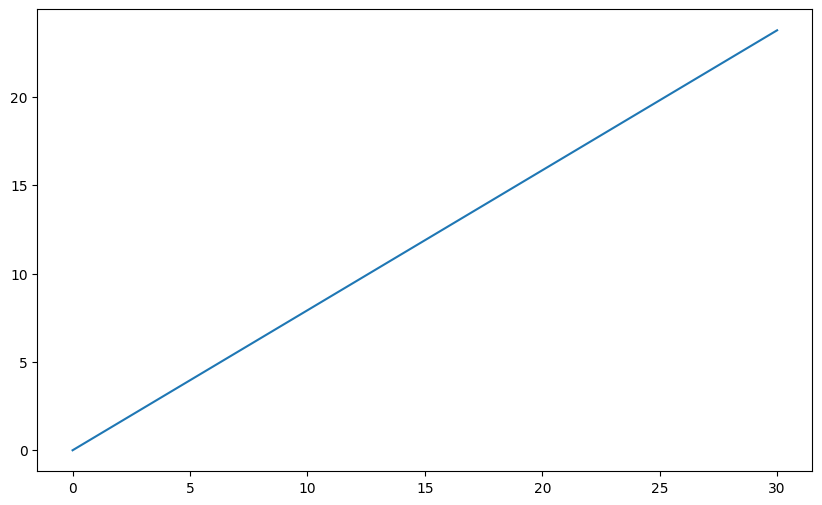

In [15]:
def masa_prop(mf, Ve, tb, V):

    mp = mf*(np.exp((V+C.g*tb)/Ve)-1)
    return mp

mf = np.linspace(0, 30, 100)
M = 0.02378
k = 1.19
T = 0.95*2884
rho = 1682*0.95

h =90000
V = (2*h*C.g)**0.5

Ve1 = Ve(T,C.R/M, k, 20, 1500)

print(V, Ve1)

mp =  masa_prop(mf, Ve1, 10, V)

plt.figure(figsize=(10, 6))
plt.plot(mf, mp)
plt.show()

In [23]:
masa_prop(30, Ve1, 8, 1600)

29.605299349922195

Longitud de po_array: 5
Longitud de pa_array: 5
Longitud de pe_solutions: 5


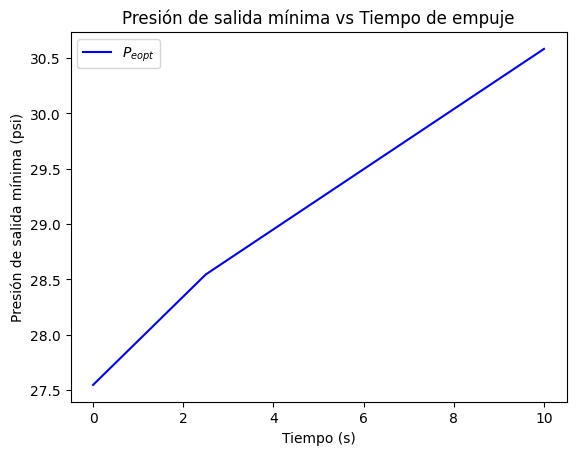

In [9]:
import numpy as np
from scipy.optimize import fsolve, minimize_scalar
import matplotlib.pyplot as plt

# Definición de la función para el coeficiente de empuje
def Cf2_(pe, po, pa, At, Ae, k):
    term1 = np.sqrt((2 * k**2 / (k - 1)) * (2 / (k + 1))**((k + 1) / (k - 1)) * (1 - (pe / po)**((k - 1) / k)))
    term2 = ((pe - pa) / po) * (Ae / At)
    return term1 + term2 - CF

# Parámetros conocidos
At = 0.1  # Área de garganta (m^2)
Ae = 0.2  # Área de salida (m^2)
CF = 1.5  # Coeficiente de empuje (dado)
k = 1.4   # Índice adiabático

# Arrays de presión de cámara y presión atmosférica
Presion_camara = np.array([101325, 110000, 120000, 130000, 140000])  # Ejemplo en Pascales
P_atm = np.array([101325, 100000, 95000, 90000, 85000])  # Ejemplo en Pascales

# Convertimos las presiones a psi (si es necesario)
po_array = (Presion_camara + P_atm) * 0.000145038  # Conversion from Pa to psi
pa_array = P_atm * 0.000145038  # Conversion from Pa to psi

# Asegurarse de que los arrays tienen la misma longitud
assert len(po_array) == len(pa_array), "Los arreglos po y pa deben tener la misma longitud"

# Inicializamos un array para almacenar las soluciones de pe
pe_solutions = []

# Función para encontrar el mínimo pe que cumple Cf >= 0
def find_pe_min(po, pa, At, Ae, k):
    # Función a minimizar
    def objective(pe):
        return np.maximum(-Cf2_(pe, po, pa, At, Ae, k), 0)
    
    result = minimize_scalar(objective, bounds=(pa, po), method='bounded')
    if result.success:
        return result.x
    else:
        return np.nan  # Indicar si no se encontró una solución válida

# Resolvemos para pe que cumple Cf >= 0 para cada par de po y pa
for po, pa in zip(po_array, pa_array):
    pe_min = find_pe_min(po, pa, At, Ae, k)
    pe_solutions.append(pe_min)

# Convertimos la lista de soluciones en un array de numpy para facilitar su manejo
pe_solutions = np.array(pe_solutions)

# Verificamos las longitudes de los arrays
print(f"Longitud de po_array: {len(po_array)}")
print(f"Longitud de pa_array: {len(pa_array)}")
print(f"Longitud de pe_solutions: {len(pe_solutions)}")

# Generación de t_thrust
t_thrust = np.linspace(0, 10, len(pe_solutions))  # Suponiendo que t_thrust tiene la misma longitud

# Graficamos los resultados
plt.plot(t_thrust, pe_solutions, 'b-', label=r'$P_{e opt}$')
plt.xlabel('Tiempo (s)')
plt.ylabel('Presión de salida mínima (psi)')
plt.title('Presión de salida mínima vs Tiempo de empuje')
plt.legend()
plt.show()



---

# Empuje

In [7]:
    # %%
    F       = [0]
    C_f     = [N_noz]
    P_e     = []
    Ae_At   = [1]
    I_t     = [0]
    Po_thrust = np.append(Presion_camara + P_a, 0.01) # presion de taill off
    P       = lambda Po: Po/((1+(k-1)/2*Me**2)**(k/(k-1))) # Funcion definida para hacer mas simple los calculos

    print(len(t_thrust))
    for j in range(len(t_thrust)-1):

        if P(Po_thrust[j]*10**6) < P_a*10**6:
            P_e.append(P_a*10**6)
        else :
            P_e.append(P(Po_thrust[j]*10**6))
        
        C_f.append(N_noz*Cf_(P_e[j], Po_thrust[j+1]*10**6, P_a*10**6, A_t, A_e, k))

        F.append(C_f[j]*Po_thrust[j]*10**6*A_t)

        I_t.append((F[j+1] + F[j])/2*(t_thrust[j+1]-t_thrust[j]))

        if Presion_camara[j] > 0 and P_a/Presion_camara[j] < 1 :
            Ae_At.append(1/(A1A2(Presion_camara[j], P_a, k))

SyntaxError: incomplete input (2590699837.py, line 25)

In [ ]:
def P_Po(Po, Me, k):
    P       =  Po/((1+(k-1)/2*Me**2)**(k/(k-1)))
    return P

def Cf_(Pe, P0, Pa, At, Ae, k):
    a = (k+1)/(k-1)
    return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)


P_e = P_Po(Presion_camara, Me, k)
CF = Cf_(P_e, Presion_camara, Pa, At, Ae, k)

F = CF*At*Presion_camara

M_e = mach(P_e, Presion_camara, k)
Ae_At = RatArea(M_e, 1, k)

---

In [6]:
Me_C= mach(14.7, 800, 1.4 )
AeAt =RatArea(Me_C, 1, 1.4)
k= 1.4
b=(k-1)/2
Te = 1730*1/(1+b*(Me_C**2))

print(Me_C, AeAt, Te)

3.2655911566515576 5.448783862815234 552.2186369228091


c:\Users\leo_1\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The solution for M is: 1.0002755879783618 AeAt = 9.393282570564594


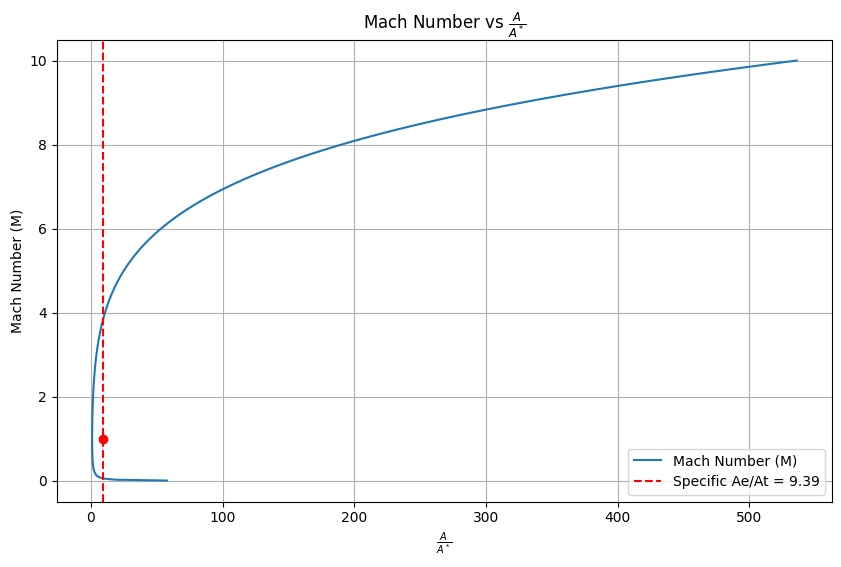

In [8]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def equation(M, A_A_star, k):
    left_side = A_A_star
    right_side = (1 / M) * ((1 + ((k - 1) / 2) * M**2) / (1 + ((k - 1) / 2)))**((k + 1) / (2 * (k - 1)))
    return right_side - left_side

def A_At(M, k):
    
    A_At = (1 / M) * ((1 + ((k - 1) / 2) * M**2) / (1 + ((k - 1) / 2)))**((k + 1) / (2 * (k - 1)))
    return A_At

def find_M(A_A_star, k):
    # Initial guess for M
    M_initial_guess = 1.0
    M_solution = fsolve(equation, M_initial_guess, args=(A_A_star, k))
    return M_solution[0]

# Parameters
De = 36.77815506739431
Dt = 12

At = np.pi*(Dt/2)**2
Ae = np.pi*(De/2)**2

AeAt =  Ae/At # Example value for A/A*
k = 1.4         # Example value for k (specific heat ratio for air)

# Find M
M = find_M(AeAt, k)
print(f"The solution for M is: {M}", f'AeAt = {AeAt}')

# Generate values for A/A* to plot

M_values = np.linspace(0.01, 10, 500)
A_At1 = A_At(M_values, k)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(A_At1, M_values, label='Mach Number (M)')
plt.axvline(AeAt, color='r', linestyle='--', label=f'Specific Ae/At = {AeAt:.2f}')
plt.scatter([AeAt], [M], color='red')  # Mark the specific solution
plt.xlabel('$\\frac{A}{A^*}$')
plt.ylabel('Mach Number (M)')
plt.title('Mach Number vs $\\frac{A}{A^*}$')
plt.legend()
plt.grid(True)
plt.show()



La solución para Me es: 3.8531954679606977 AeAt = 9.393282570564594
El valor de Pe es: 8.02516812741455


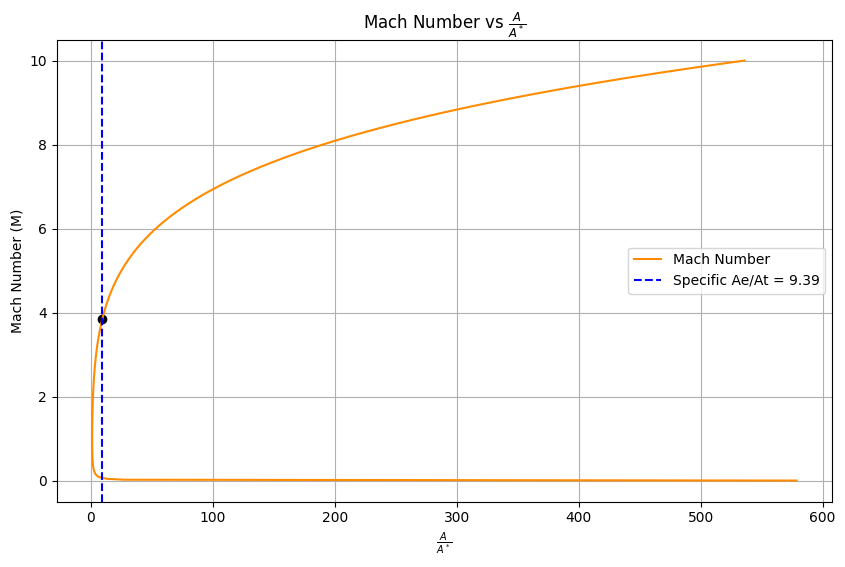

In [19]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def equation(M, A_A_star, k):
    left_side = A_A_star
    right_side = (1 / M) * ((1 + ((k - 1) / 2) * M**2) / (1 + ((k - 1) / 2)))**((k + 1) / (2 * (k - 1)))
    return right_side - left_side

def A_At(M, k):
    A_At = (1 / M) * ((1 + ((k - 1) / 2) * M**2) / (1 + ((k - 1) / 2)))**((k + 1) / (2 * (k - 1)))
    return A_At

def find_M(A_A_star, k, initial_guess):
    M_solution = fsolve(equation, initial_guess, args=(A_A_star, k))
    return M_solution[0]

def P(Po, M, k):
    P       =  Po/((1+(k-1)/2*M**2)**(k/(k-1)))
    return P

# Parameters
Po = 1000

De = 36.77815506739431
Dt = 12

At = np.pi*(Dt/2)**2
Ae = np.pi*(De/2)**2

AeAt =  Ae/At # Example value for A/A*
k = 1.4         # Example value for k (specific heat ratio for air)

# Find M, using a higher initial guess to ensure finding the higher M value
Me = find_M(AeAt, k, initial_guess=5.0)
Pe = P(Po, Me, k)
print(f"La solución para Me es: {Me}", f'AeAt = {AeAt}')
print(f'El valor de Pe es: {Pe}')

# Generate values for A/A* to plot
M_values = np.linspace(1e-3, 10, 500)
A_At1 = A_At(M_values, k)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(A_At1, M_values, label='Mach Number ', color= '#FF8C00')
plt.scatter([AeAt], [Me], color='black')  # Mark the specific solution
plt.axvline(AeAt, color='b', linestyle='--', label=f'Specific Ae/At = {AeAt:.2f}')
plt.xlabel('$\\frac{A}{A^*}$')
plt.ylabel('Mach Number (M)')
plt.title('Mach Number vs $\\frac{A}{A^*}$')
plt.legend()
plt.grid(True)
plt.show()


Para un Ae/At = 9.393282570564594 se tienen los valores:
La solución para Me es: 3.8531954679606915
El valor de Pe es: 7.545423576757774


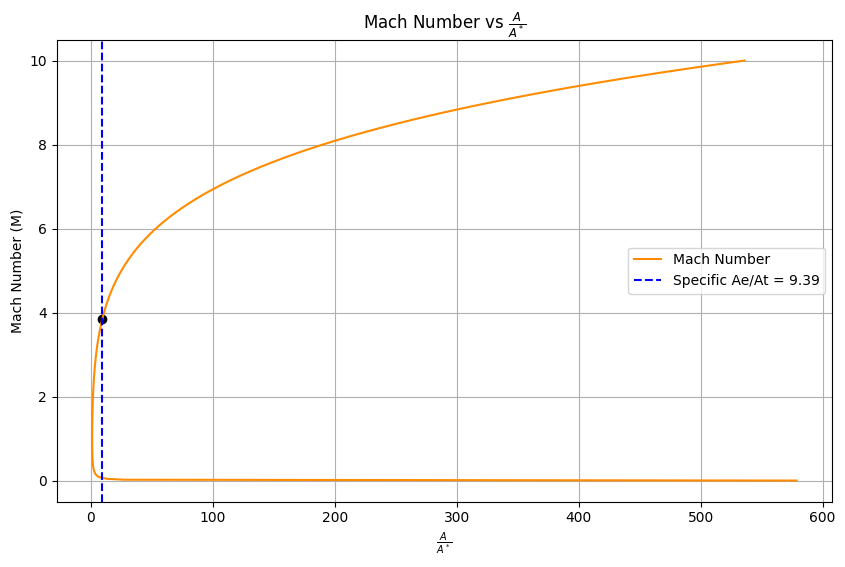

In [22]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

def equation(M, A_A_star, k):
    right_side = (1 / M) * ((1 + ((k - 1) / 2) * M**2) / (1 + ((k - 1) / 2)))**((k + 1) / (2 * (k - 1)))
    return right_side - A_A_star

def A_At(M, k):
    A_At = (1 / M) * ((1 + ((k - 1) / 2) * M**2) / (1 + ((k - 1) / 2)))**((k + 1) / (2 * (k - 1)))
    return A_At

def find_M(A_A_star, k):
    # Use root_scalar with the Brent method to find the higher M value
    sol = root_scalar(equation, args=(A_A_star, k), bracket=[1, 10], method='brentq')
    return sol.root

def P(Po, M, k):
    P = Po / ((1 + (k - 1) / 2 * M**2)**(k / (k - 1)))
    return P

# Parameters
Po = 940.22

De = 36.77815506739431
Dt = 12

At = np.pi * (Dt / 2)**2
Ae = np.pi * (De / 2)**2

AeAt = Ae / At # Example value for A/A*
k = 1.4         # Example value for k (specific heat ratio for air)

# Find M, using root_scalar with the Brent method to ensure finding the higher M value
Me = find_M(AeAt, k)
Pe = P(Po, Me, k)
print( f'Para un Ae/At = {AeAt} se tienen los valores:')
print(f"La solución para Me es: {Me}",)
print(f'El valor de Pe es: {Pe}')

# Generate values for A/A* to plot
M_values = np.linspace(1e-3, 10, 500)
A_At1 = A_At(M_values, k)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(A_At1, M_values, label='Mach Number', color='#FF8C00')
plt.scatter([AeAt], [Me], color='black')  # Mark the specific solution
plt.axvline(AeAt, color='b', linestyle='--', label=f'Specific Ae/At = {AeAt:.2f}')
plt.xlabel('$\\frac{A}{A^*}$')
plt.ylabel('Mach Number (M)')
plt.title('Mach Number vs $\\frac{A}{A^*}$')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
#Me2= mach(9, 1000, 1.4)
#P       = lambda Po: Po/((1+(k-1)/2*Me2**2)**(k/(k-1)))

print(P(1000))


NameError: name 'mach' is not defined

In [4]:
ex_vel(C.R, 1722.15, 1.133, 0.03719)

976.8705000028659

In [15]:
eta_c = 0.95
eta=0.85

P0 = 1000
Pe = 14.69
T0 = 1720*eta_c
M = 0.04202
k = 1.1333
a = 8.26
n = 0.319

rho= 0.95*1889

D= 2.562*25.4 #mm
Dp = 1.02*25.4 #mm
h = 2000
m = 15
L0 = (3*D+Dp)/2
c = ex_vel(C.R,T0,k,M)
#rho_atm= 1.225
#Df= 4*25.4*10**-3
#Cd=0.45



tb= (D-Dp)/(2*a*(P0/145.038)**n)
V = np.sqrt(2*C.g*h)
Ve1 = Ve(T0, C.R/M,k,Pe,P0)*eta
#Fd= rho_atm*(np.pi*(Df/2)**2)*Cd*(V)**2/2

mp = m*(np.exp((V+(C.g)*tb)/Ve1)-1)
N = round(mp/(rho)/(((np.pi*((D*10**-3)/2)**2-np.pi*((Dp*10**-3)/2)**2)*(L0*10**-3))))
N1= mp/(rho)/((np.pi*((D*10**-3)/2)**2-np.pi*((Dp*10**-3)/2)**2)*(L0*10**-3))
x=(L0-2*Dp)/6
d= Dp+2*x
L= L0-2*x
ti= (D-Dp)/2

Ab_max = N*(np.pi*(D**2-d**2)/2+np.pi*L*d)
Ab_in = N*(np.pi*(D**2-Dp**2)/2+np.pi*L0*Dp)

Ab_fin = N*np.pi*D*(L0-2*ti)

#Dt2= (2*10**3)*np.sqrt(((Ab_max*10**-6)*c*((a*10**(-6*n))*10**-3))*rho*(P0*6894.76)**(n-1))/np.pi
#At2=np.pi*(Dt2/2)**2


ApAt = 2 #(Dp/Dt)**2
Dt= 1/np.sqrt(ApAt)*(Dp)
At= np.pi*(Dt/2)**2
######### Calcular Kn #############
Kn_in =  Ab_in/At
Kn_max= Ab_max/At
Kn_fin = Ab_fin/At

P0_max = presion(Kn_max, a*10**(-3-6*n),rho, n,k,C.R/M,T0)*10**-6*145 
P0_in = presion(Kn_in, a*10**(-3-6*n),rho, n,k,C.R/M,T0)*10**-6*145 
P0_fin = presion(Kn_fin, a*10**(-3-6*n),rho, n,k,C.R/M,T0)*10**-6*145

P0_prom= (P0_in+P0_fin+ P0_max)/3


Me = mach(Pe, P0_prom, k)

AeAt = RatArea(Me, 1, k)

Ae = AeAt*At
De = np.sqrt(4*Ae/np.pi)

F = mdot(At*10**-6,P0_prom*6894.76,k,T0,C.R/M)*Ve1

It= F*tb

print(N1)
print(f'D={D}', f'Dp = {Dp}', tb,Ve1, c, V, f'mp={mp}', f'L0={L0}',  N, f'Dt={Dt}', ApAt)
print(Kn_in ,Kn_max, Kn_fin)
print(P0_in, P0_max, P0_fin, f'P0_prom={P0_prom}')
print(AeAt, f'De={De}')
print(F, It)
print(At)



4.971370571975865
D=65.0748 Dp = 25.907999999999998 1.2806213629610899 1246.698645989589 895.098245884469 198.05706248452742 mp=2.7607135955431383 L0=110.5662 5 Dt=18.31972248698107 2
276.8851211072665 311.1666089965398 276.8851211072665
979.9091708646001 1163.1224093573408 979.9091708646001 P0_prom=1040.9802503621804
10.534233395389377 De=59.459377580290614
2634.9967731499064 3374.433159029307
263.58923062651826


v0=289.77184040017704 Va=1828.1595117067097
0.5528310000000001 552.831
V_f= 1875.2691352193701 V_c= 1828.1595117067097
x_f= 2845.2541704177834 19.583399999999997
P0_prom= 914.2458681174834 P0_max= 1125.5333374216193


C:\Users\leo_1\AppData\Local\Temp\ipykernel_11116\866920807.py:80: RuntimeWarning: invalid value encountered in power
  r = a*(Sol_1[:, 0] / 1e6)**n


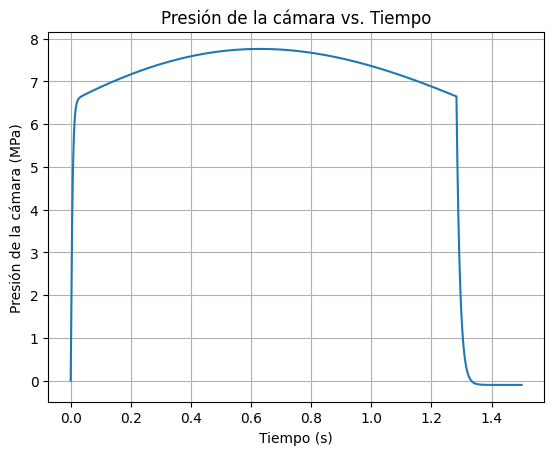

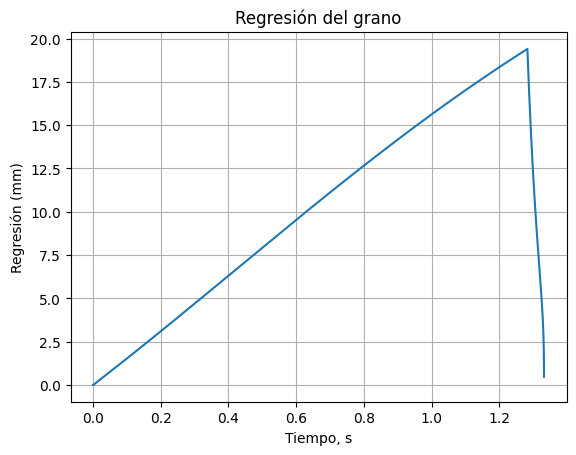

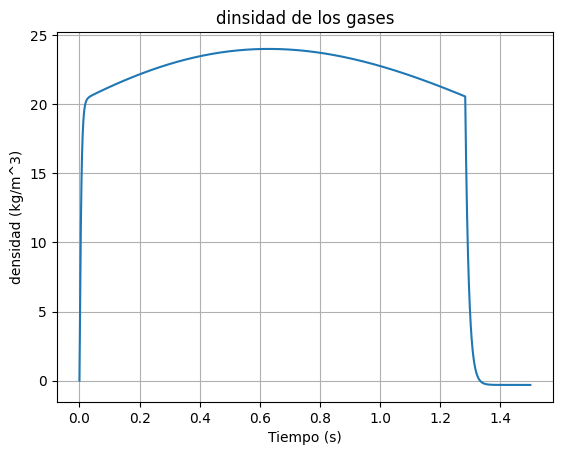

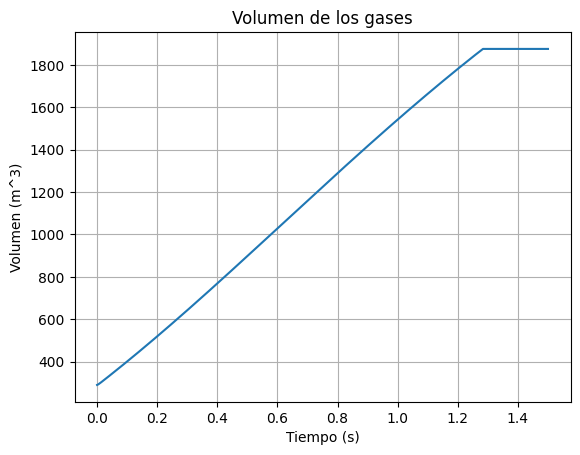

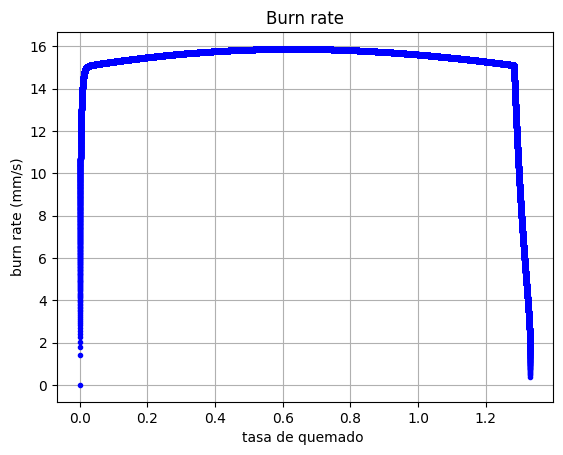

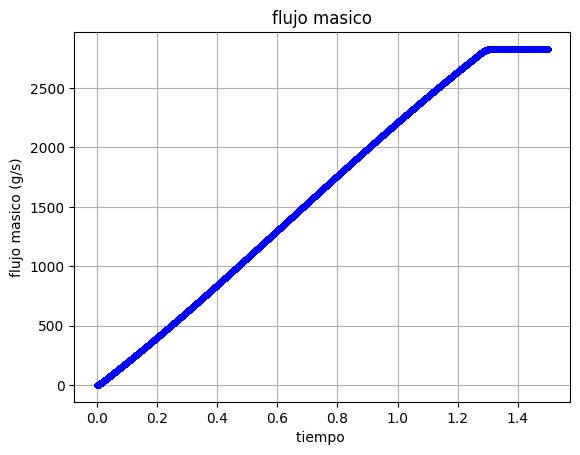

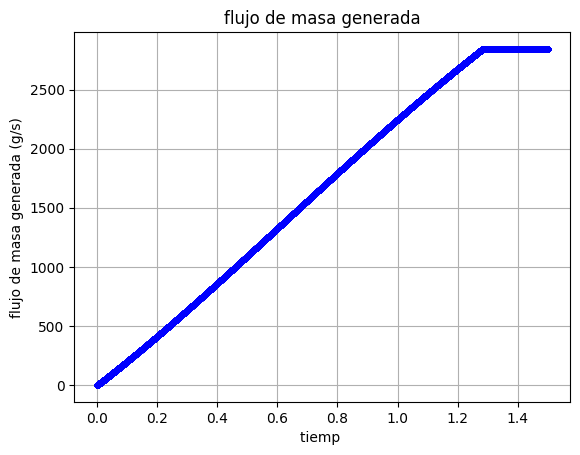

In [100]:
fase2_activa = False
vf = 0
def Ec_Presion(CI, t, p):
    global fase2_activa, vf
    a, n, Dc, Dp, Lg0, Bs, In, rho_p, k ,M , To, At, N= p
    Po, rho_0, v0, m, mg = CI
    
    
    r = a*(Po+101325)**n
    x = r*t
    #print(x <=(Dc-Dp)/2, x*10**3, fase2_activa)

    D = Dc - 2*In - Bs[0]*2*x # m
    d = Dp + Bs[1]*2*x        # m
    L = Lg0 - Bs[2]*N*2*x      # m


    Ab_e = Bs[2]*2*N*np.pi*(D*D-d*d)/4
    Ab_c = Bs[1]*np.pi*d*L
    Ab_s = Bs[0]*np.pi*D*L
    Ab = Ab_e + Ab_c + Ab_s # mm^2


    dmdt = At * (Po + 101325) * np.sqrt((1 / (C.R/M * To)) * k * (2 / (k + 1)) ** ((k + 1) / (k - 1)))

    if x <=(Dc-Dp)/2 and not fase2_activa:
        dmgdt = Ab*r*rho_p
        dP0dt = (C.R * To / (M * v0)) * (dmgdt -Ab * r * rho_0 - dmdt )
        dv0dt = Ab*r
        vf = dv0dt
    else :
        #print('fase 2')
        fase2_activa = True

        dmgdt = 0
        dP0dt = (C.R * To / (M * vf)) * (- dmdt)
        dv0dt = 0
        #print(vf*10**6)

                         
    drho_0dt = 1/(C.R/M*To)*dP0dt


    return [dP0dt, drho_0dt,  dv0dt, dmdt, dmgdt]


Bs = [0, 1, 1]

In=0

V0 = mp/rho # kg/m^3 volumen del grano
Va0 = (V0)/(1-ApAt*At*4/(np.pi*(D - 2*In)**2)) # m^3 Volumen disponible de la camara

v0 = Va0-V0
print(f'v0={v0*10**6}', f'Va={Va0*10**6}') # cm^^3




Lg0 = N*L0*10**-3#V0/(np.pi/4*((D*10**-3 - 2*In*10**-3)**2-(Dp*10**-3)**2))
print(Lg0, L0*N)
CI = [0, 0, v0, 0, 0]

p1= [a*10**(-3-6*n), n, D*10**-3, Dp*10**-3, Lg0, Bs, In, rho, k ,M , T0, At*10**-6, 5]

#print(p1)

t = np.linspace(0,1.5, 200000)
Sol_1 = odeint(Ec_Presion, CI, t, args=(p1, ))

print(f'V_f= {np.nanmax(Sol_1[:, 2]*10**6)}',f'V_c= {Va0*10**6}')
print(f'x_f= {np.nanmax(Sol_1[:, 4]*10**3)}', (D-Dp)/2)


print(f'P0_prom= {np.nanmean(Sol_1[:, 0]*10**-6*145)}', f'P0_max= {np.nanmax(Sol_1[:, 0]*10**-6*145)}')


##############################################

r = a*(Sol_1[:, 0] / 1e6)**n
x = r*t 
# Gráfica de los resultados
plt.figure()
plt.plot(t, Sol_1[:, 0] / 1e6)  # Presión en MPa
plt.xlabel('Tiempo (s)')
plt.ylabel('Presión de la cámara (MPa)')
plt.title('Presión de la cámara vs. Tiempo')
plt.grid(True)
plt.show()


plt.figure()
plt.plot(t, x)  # Presión en MPa
plt.xlabel('Tiempo, s')
plt.ylabel('Regresión (mm)')
plt.title('Regresión del grano')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, Sol_1[:, 1]) 
plt.xlabel('Tiempo (s)')
plt.ylabel('densidad (kg/m^3)')
plt.title('dinsidad de los gases')
plt.grid(True)
plt.show()


plt.figure()
plt.plot(t, Sol_1[:, 2]*10**6) 
plt.xlabel('Tiempo (s)')
plt.ylabel('Volumen (m^3)')
plt.title('Volumen de los gases')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, r, '.b' ) 
plt.xlabel('tasa de quemado ')
plt.ylabel('burn rate (mm/s)')
plt.title('Burn rate')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, Sol_1[:, 3]*10**3, '.b' ) 
plt.xlabel('tiempo ')
plt.ylabel('flujo masico (g/s)')
plt.title('flujo masico')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, Sol_1[:, 4]*10**3, '.b' ) 
plt.xlabel('tiemp ')
plt.ylabel('flujo de masa generada (g/s)')
plt.title('flujo de masa generada')
plt.grid(True)
plt.show()



D-dp19.583399999999997
v0=289.77184040017704 Va=1828.1595117067097
0.5528310000000001 552.831
V_f= 1871.967375771915 V_c= 1828.1595117067097
x_f= 2839.328998001352 19.583399999999997
P0_prom= 917.0772091753289 P0_max= 1125.5333371284846


C:\Users\leo_1\AppData\Local\Temp\ipykernel_22084\1424841854.py:79: RuntimeWarning: invalid value encountered in power
  r = a*(Sol_1[:, 0] / 1e6)**n


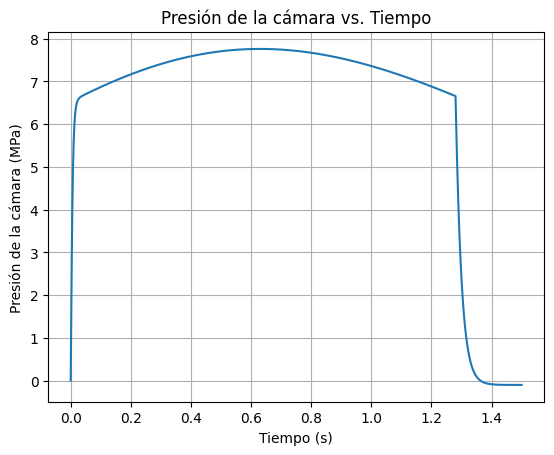

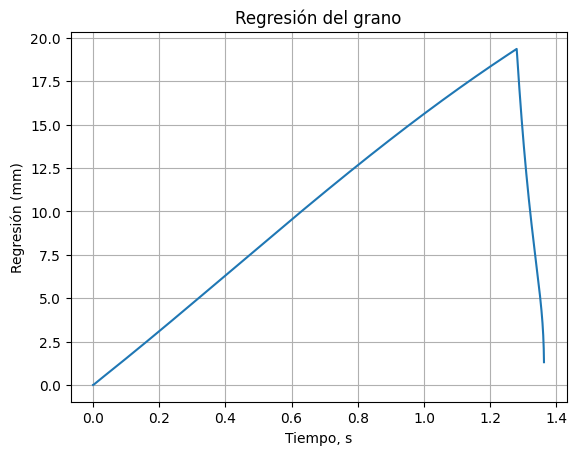

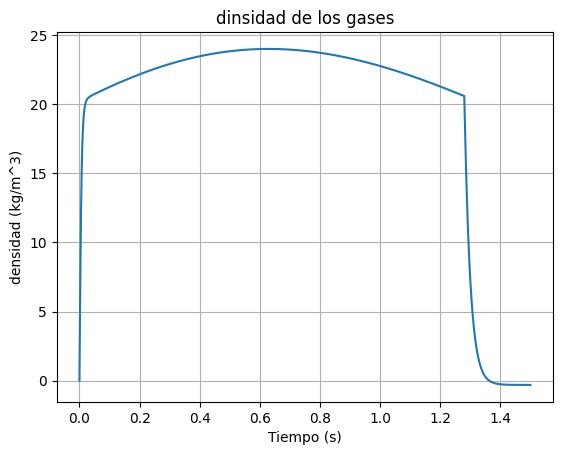

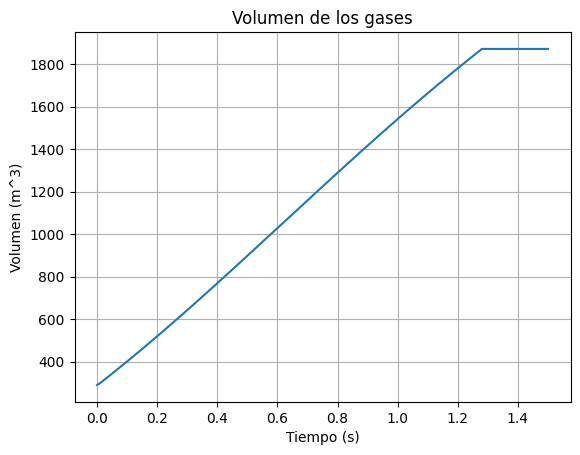

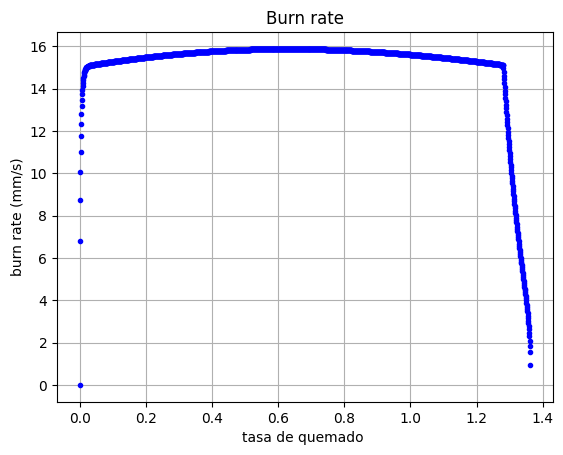

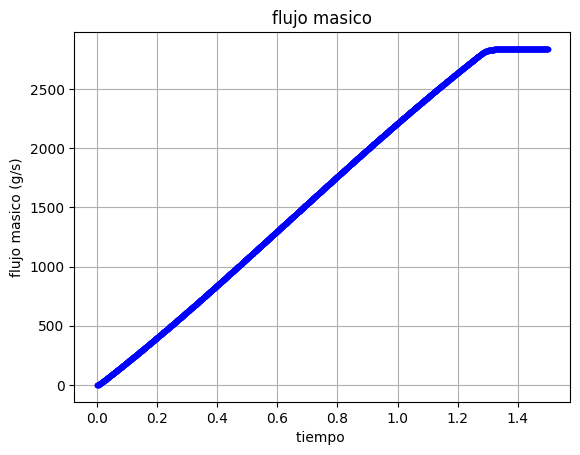

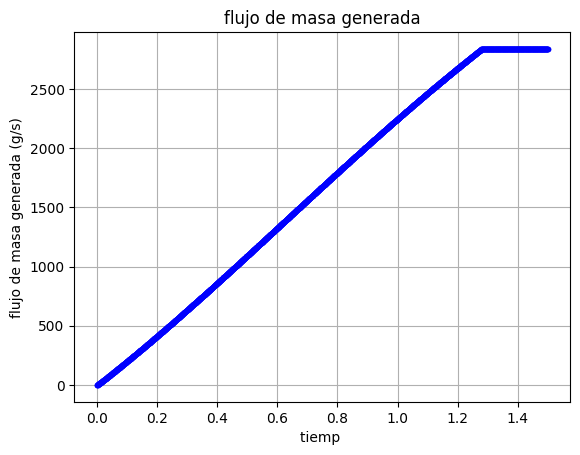

In [5]:
fase2_activa = False

def Ab_(Dg, In, Dp, Lg0, x, N, Bs):
    D = Dg - 2*In - Bs[0]*2*x # m
    d = Dp + Bs[1]*2*x        # m
    L = Lg0 - Bs[2]*N*2*x      # m


    Ab_e = Bs[2]*2*N*np.pi*(D*D-d*d)/4
    Ab_c = Bs[1]*np.pi*d*L
    Ab_s = Bs[0]*np.pi*D*L

    if x <=(Dg-Dp)/2 and x > 0:
        Ab = Ab_e + Ab_c + Ab_s # mm^2
    else:
        Ab = 0

    return Ab

def Ec_Presion(CI, t, p):
    global fase2_activa
    a, n, Dc, Dp, Lg0, Bs, In, rho_p, k ,M , To, At, N= p
    Po, rho_0, v0, m, mg = CI
                         
                         
    r = a*(Po+101325)**n
    if r*t <=(Dc-Dp)/2 and not fase2_activa:
        x = r*t
    else:
        fase2_activa = True
        x = 0
    Ab = Ab_(Dc, In, Dp, Lg0, x, N, Bs)


    dmdt = At * (Po + 101325) * np.sqrt((1 / (C.R/M * To)) * k * (2 / (k + 1)) ** ((k + 1) / (k - 1)))
    dmgdt = Ab*r*rho_p
    dP0dt = (C.R * To / (M * v0)) * (dmgdt - Ab * r * rho_0 - dmdt )
    dv0dt = Ab*r
    # print(x*10**3 ,Ab*10**3, v0*10**6)
    drho_0dt = 1/(C.R/M*To)*dP0dt


    return [dP0dt, drho_0dt,  dv0dt, dmdt, dmgdt]

print(f'D-dp{(D-Dp)/2}')
Bs = [0, 1, 1]

In=0

V0 = mp/rho # kg/m^3 volumen del grano
Va0 = (V0)/(1-ApAt*At*4/(np.pi*(D - 2*In)**2)) # m^3 Volumen disponible de la camara

v0 = Va0-V0
print(f'v0={v0*10**6}', f'Va={Va0*10**6}') # cm^^3




Lg0 = N*L0*10**-3 #V0/(np.pi/4*((D*10**-3 - 2*In*10**-3)**2-(Dp*10**-3)**2))
print(Lg0, L0*N)
CI = [0, 0, v0, 0, 0]

p1= [a*10**(-3-6*n), n, D*10**-3, Dp*10**-3, Lg0, Bs, In, rho, k ,M , T0, At*10**-6, 5]

#print(p1)

t = np.linspace(0,1.5, 2000)
Sol_1 = odeint(Ec_Presion, CI, t, args=(p1, ))

print(f'V_f= {np.nanmax(Sol_1[:, 2]*10**6)}',f'V_c= {Va0*10**6}')
print(f'x_f= {np.nanmax(Sol_1[:, 4]*10**3)}', (D-Dp)/2)


print(f'P0_prom= {np.nanmean(Sol_1[:, 0]*10**-6*145)}', f'P0_max= {np.nanmax(Sol_1[:, 0]*10**-6*145)}')


##############################################

r = a*(Sol_1[:, 0] / 1e6)**n
x = r*t 
# Gráfica de los resultados
plt.figure()
plt.plot(t, Sol_1[:, 0] / 1e6)  # Presión en MPa
plt.xlabel('Tiempo (s)')
plt.ylabel('Presión de la cámara (MPa)')
plt.title('Presión de la cámara vs. Tiempo')
plt.grid(True)
plt.show()


plt.figure()
plt.plot(t, x)  # Presión en MPa
plt.xlabel('Tiempo, s')
plt.ylabel('Regresión (mm)')
plt.title('Regresión del grano')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, Sol_1[:, 1]) 
plt.xlabel('Tiempo (s)')
plt.ylabel('densidad (kg/m^3)')
plt.title('dinsidad de los gases')
plt.grid(True)
plt.show()


plt.figure()
plt.plot(t, Sol_1[:, 2]*10**6) 
plt.xlabel('Tiempo (s)')
plt.ylabel('Volumen (m^3)')
plt.title('Volumen de los gases')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, r, '.b' ) 
plt.xlabel('tasa de quemado ')
plt.ylabel('burn rate (mm/s)')
plt.title('Burn rate')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, Sol_1[:, 3]*10**3, '.b' ) 
plt.xlabel('tiempo ')
plt.ylabel('flujo masico (g/s)')
plt.title('flujo masico')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, Sol_1[:, 4]*10**3, '.b' ) 
plt.xlabel('tiemp ')
plt.ylabel('flujo de masa generada (g/s)')
plt.title('flujo de masa generada')
plt.grid(True)
plt.show()


v0=289.77184040017704 Va=1828.1595117067097
0.5528310000000001 552.831
[0.00010068854087119405, 0.319, 0.0650748, 0.025907999999999997, 0.5528310000000001, [0, 1, 1], 0, 1794.55, 1.1333, 0.04202, 1634.0, 0.00026358923062651826, 5]
x=0.0 r=3.9792721893222236 0.0
x=2.685340464204431e-13 r=3.979272189294077 6.748320638706573e-14
x=5.37068092768709e-12 r=3.979272188759298 1.3496641277413148e-12
x=8.056021413354905e-12 r=3.979272199539397 2.024496191611972e-12
x=2.1482723654446984e-11 r=3.9792721783305223 5.398656510965259e-12
x=2.3869692391720404e-11 r=3.979272085363204 5.998507234405843e-12
x=2.6853404010712034e-11 r=3.9792720957400936 6.7483206387065734e-12
x=2.685340492476559e-11 r=3.9792722311891344 6.7483206387065734e-12
x=3.2409713820734456e-11 r=3.9792722407790944 8.144633455485574e-12
x=3.5187868278761825e-11 r=3.979272245574074 8.842789863875074e-12
x=4.9078640669328066e-11 r=3.9792722695489733 1.2333571905822577e-11
x=5.154811133406331e-11 r=3.9792722738111768 1.2954155379946577e

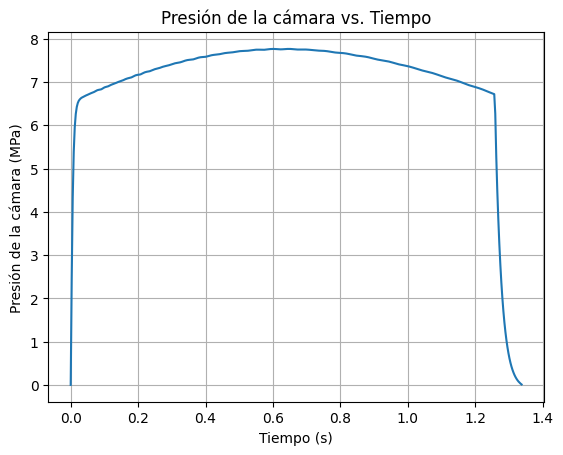

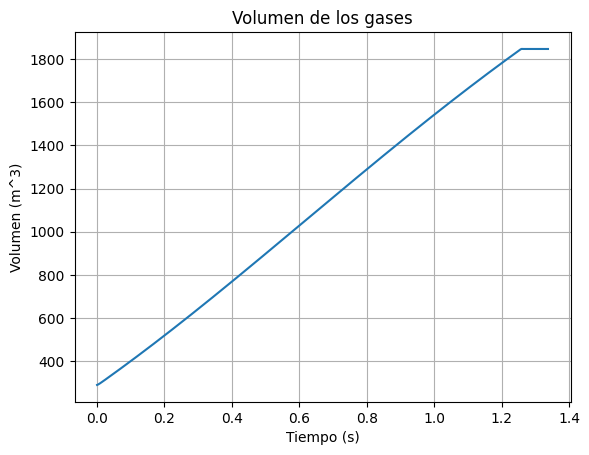

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

fase2_activa = False

def Ab_(Dg, In, Dp, Lg0, x, N, Bs):
    D = Dg - 2 * In - Bs[0] * 2 * x 
    d = Dp + Bs[1] * 2 * x          
    L = Lg0 - Bs[2] * N * 2 * x     

    Ab_e = Bs[2] * 2 * N * np.pi * (D**2 - d**2) / 4
    Ab_c = Bs[1] * np.pi * d * L
    Ab_s = Bs[0] * np.pi * D * L

    if x <= (Dg - Dp) / 2 and x > 0:
        Ab = Ab_e + Ab_c + Ab_s 
    else:
        Ab = 0

    return Ab

def Ec_Presion(t, CI, p):
    global fase2_activa, tb
    a, n, Dc, Dp, Lg0, Bs, In, rho_p, k, M, To, At, N = p
    Po, rho_0, v0, m, mg = CI
    
    r = a * (Po + 101325)**n
    if r * t <= (Dc - Dp) / 2 and not fase2_activa:
        x = r * t
    else:
        if r * t >= (Dc - Dp) / 2 and not fase2_activa:
                tb = t
        else:
            next
        fase2_activa = True
        x = 0
    Ab = Ab_(Dc, In, Dp, Lg0, x, N, Bs)
    print(f'x={x*10**3}', f'r={r*10**3}', t)

    dmdt = At * (Po + 101325) * np.sqrt((1 / (C.R / M * To)) * k * (2 / (k + 1)) ** ((k + 1) / (k - 1)))
    dmgdt = Ab * r * rho_p
    dP0dt = (C.R * To / (M * v0)) * (dmgdt - Ab * r * rho_0 - dmdt)
    dv0dt = Ab * r
    drho_0dt = 1 / (C.R / M * To) * dP0dt

    return [dP0dt, drho_0dt, dv0dt, dmdt, dmgdt]

def event_pressure_zero(t, CI, p):
    Po, rho_0, v0, m, mg = CI
    return Po

event_pressure_zero.terminal = True
event_pressure_zero.direction = -1


Bs = [0, 1, 1]
In = 0

V0 = mp / rho  # kg/m^3 volumen del grano
Va0 = V0 / (1 - ApAt * At * 4 / (np.pi * (D - 2 * In)**2)) # m^3 Volumen disponible de la camara

v0 = Va0 - V0
print(f'v0={v0*10**6}', f'Va={Va0*10**6}') # cm^^3

Lg0 = N * L0 * 10**-3
print(Lg0, L0 * N)
CI = [0, 0, v0, 0, 0]

p1 = [a * 10**(-3-6*n), n, D * 10**-3, Dp * 10**-3, Lg0, Bs, In, rho, k, M, T0, At * 10**-6, N]

print(p1)

t_span = (0, 1.5)
t_eval = np.linspace(0, 1.5, 500)
sol = solve_ivp(Ec_Presion, t_span, CI, args=(p1,), events=event_pressure_zero, t_eval=t_eval)

print(f'V_f= {np.nanmax(sol.y[2] * 10**6)}', f'V_c= {Va0 * 10**6}')
print(f'P0_prom= {np.nanmean(sol.y[0] * 10**-6 * 145)}', f'P0_max= {np.nanmax(sol.y[0] * 10**-6 * 145)}')

print(sol.t[-1], tb)


# Gráfica de los resultados
plt.figure()
plt.plot(sol.t, sol.y[0] / 1e6)  # Presión en MPa
plt.xlabel('Tiempo (s)')
plt.ylabel('Presión de la cámara (MPa)')
plt.title('Presión de la cámara vs. Tiempo')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(sol.t, sol.y[2] * 10**6) 
plt.xlabel('Tiempo (s)')
plt.ylabel('Volumen (m^3)')
plt.title('Volumen de los gases')
plt.grid(True)
plt.show()

# Añadir las demás gráficas necesarias


v0=289.77184040017704 Va=1828.1595117067097
[0.00010068854087119405, 0.319, 0.0650748, 0.025907999999999997, 0.549665552935198, [0, 1, 1], 0, 1794.55, 1.1333, 0.04202, 1634.0, 0.00026358923062651826, 5]
True


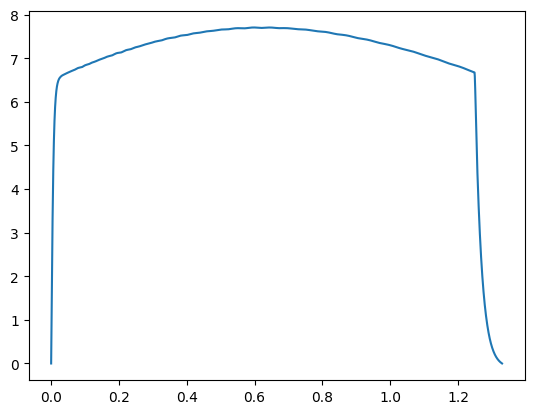

In [37]:
def Ab_(Dg, In, Dp, Lg0, x, N, Bs):
    D = Dg - 2 * In - Bs[0] * 2 * x # m
    d = Dp + Bs[1] * 2 * x          # m
    L = Lg0 - Bs[2] * N * 2 * x     # m

    Ab_e = Bs[2] * 2 * N * np.pi * (D**2 - d**2) / 4
    Ab_c = Bs[1] * np.pi * d * L
    Ab_s = Bs[0] * np.pi * D * L


    if type(x) ==  np.ndarray:
        Ab = Ab_e + Ab_c + Ab_s
    elif x <= (Dg - Dp) / 2 and x > 0 :
        Ab = Ab_e + Ab_c + Ab_s # mm^2
    else:
        Ab = 0

    return Ab


Dc= D
To=T0
# Área de quemado
V0 = mp/(rho) # m^3 Volumen con densidad experiemental del grano
Vc = (V0)/(1-ApAt*At*4/(np.pi*(Dc - 2*In)**2)) # m^3 Volumen disponible de la camara
v0 = Vc - V0 # m^3 volumen libre de la cámara

print(f'v0={v0*10**6}', f'Va={Vc*10**6}') # cm^^3
    
#Lc = Vc*10**9/Ac # mm Longitud de la cámara
Lg0 = V0/(np.pi/4*((Dc - 2*In)**2-Dp**2)) # mm  Longitud del grano con densidad experimental


    # %%

A_t = At*10**-6 # Área de la garganta en m^3
A_e = Ae*10**-6 # Área de la salida en m^3
P_a = 0.101325 # Mpa Presión atmosferica
    
fase2_activa = False
tb = 0

def Ec_Presion(t, CI, p):
    global fase2_activa, tb
    a, n, Dc, Dp, Lg0, Bs, In, rho_p, k, M, To, At, N = p
    Po, rho_0, v0, m, mg = CI
        
    r = a * (Po + 101325)**n
    if r * t <= (Dc - Dp) / 2 and not fase2_activa:
        x = r * t
    else:
        if r * t >= (Dc - Dp) / 2 and not fase2_activa:
                tb = t
        else:
            next
        fase2_activa = True
        x = 0
    Ab = Ab_(Dc, In, Dp, Lg0, x, N, Bs)
        #print(f'x={x*10**3}', f'r={r*10**3}')
        #print(Ab*10**3, x*10**3, Po, rho_0, v0, t)

    dmdt = At * (Po + 101325) * np.sqrt((1 / (C.R / M * To)) * k * (2 / (k + 1)) ** ((k + 1) / (k - 1)))
    dmgdt = Ab * r * rho_p
    dP0dt = (C.R * To / (M * v0)) * (dmgdt - Ab * r * rho_0 - dmdt)
    dv0dt = Ab * r
    drho_0dt = 1 / (C.R / M * To) * dP0dt

    return [dP0dt, drho_0dt, dv0dt, dmdt, dmgdt]

def event_pressure_zero(t, CI, p):
    Po, rho_0, v0, m, mg = CI
    return Po

event_pressure_zero.terminal = True
event_pressure_zero.direction = -1




CI_P = [0, 0, v0, 0, 0]

p_P = [a * 10**(-3-6*n), n, Dc* 10**-3, Dp * 10**-3, Lg0*10**6, Bs, In, rho, k, M, To, A_t, N]
print(p_P)


t_span = (0, 3)
t_eval = np.linspace(0, 3, 10000)
sol = solve_ivp(Ec_Presion, t_span, CI_P, args=(p_P,), events=event_pressure_zero, t_eval=t_eval)

Presion_camara = sol.y[0]/1e6 # Mpa
t_thrust = sol.t
#print(f'Po={Presion_camara}')
#print(f't={sol.t}')

r = a*(Presion_camara)**n # mm/s
X = r*t_thrust            # mm

print(type(X) ==  np.ndarray)

Ab = Ab_(Dc, In, Dp, Lg0, X, N, Bs)
Kn = Ab/At
Po_max = np.nanmax(Presion_camara) 

plt.plot(t_thrust, Presion_camara)

2776.710475930861 263.58923062651826


C:\Users\leo_1\AppData\Local\Temp\ipykernel_4256\1694118473.py:7: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)
C:\Users\leo_1\AppData\Local\Temp\ipykernel_4256\1694118473.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)
C:\Users\leo_1\AppData\Local\Temp\ipykernel_4256\4170198922.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((2/(k-1))*((Po/P)**a - 1))


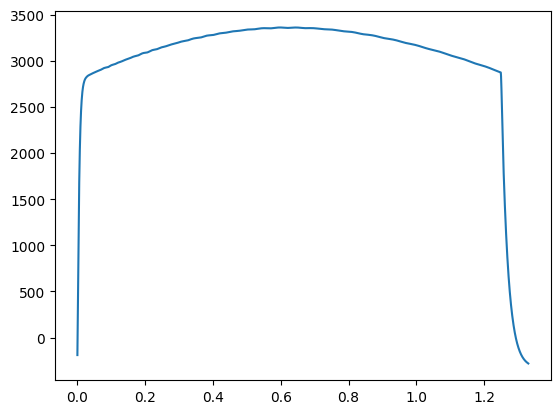

In [50]:
def P_Po(Po, Me, k):
    P       =  Po/((1+(k-1)/2*Me**2)**(k/(k-1)))
    return P

def Cf_(Pe, P0, Pa, At, Ae, k):
    a = (k+1)/(k-1)
    return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)

Pa = 14.69594878
P_e = P_Po(Presion_camara, Me, k)
print(Ae, At)
CF = Cf_(P_e*1e6, Presion_camara*1e6, Pa*1e6/145, At*1e-6, Ae*1e-6, k)

F = CF*At*Presion_camara

M_e = mach(P_e, Presion_camara, k)
Ae_At = RatArea(M_e, 1, k)

plt.plot(t_thrust, F)

In [ ]:
    # %%
    F       = [0]
    C_f     = [N_noz]
    P_e     = []
    Ae_At   = [1]
    I_t     = [0]
    Po_thrust = np.append(Presion_camara + P_a, 0.01) # presion de taill off
    P       = lambda Po: Po/((1+(k-1)/2*Me**2)**(k/(k-1))) # Funcion definida para hacer mas simple los calculos

    print(len(t_thrust))
    for j in range(len(t_thrust)-1):

        if P(Po_thrust[j]*10**6) < P_a*10**6:
            P_e.append(P_a*10**6)
        else :
            P_e.append(P(Po_thrust[j]*10**6))
        
        C_f.append(N_noz*Cf_(P_e[j], Po_thrust[j+1]*10**6, P_a*10**6, A_t, A_e, k))

        F.append(C_f[j]*Po_thrust[j]*10**6*A_t)

        I_t.append((F[j+1] + F[j])/2*(t_thrust[j+1]-t_thrust[j]))

        if Presion_camara[j] > 0 and P_a/Presion_camara[j] < 1 :
            Ae_At.append(1/(A1A2(Presion_camara[j], P_a, k)))

In [123]:
X =[1,4,5,6]
print(type(X))

if type(X) == list:
    print(3)
else:
    next

<class 'list'>
3


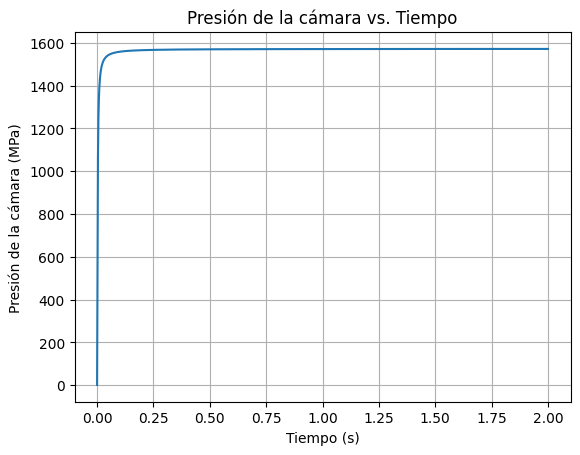

[1.00000000e+06 2.78846159e+08 6.55960355e+08 ... 1.57138919e+09
 1.57138947e+09 1.57138975e+09]


In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Definiciones de constantes
R = 8314.5  # Constante de los gases ideales, J/(kmol·K)
M = 24.45  # Masa molar promedio de los gases de combustión, kg/kmol
k = 1.22  # Coeficiente adiabático (relación de calores específicos)
At = 0.001  # Área de la garganta de la tobera, m^2
a = 0.001  # Coeficiente de velocidad de combustión
n = 0.5  # Exponente de presión
rho_p = 1800  # Densidad del propelente, kg/m^3
Ab = 0.02  # Área de combustión del grano, m^2

# Función que define el sistema de ecuaciones diferenciales
def Ec_Presion(CI, t, params):
    Po, rho_0, v0 = CI
    a, n, Ab, rho_p, k, M, R, To, At = params

    # Velocidad de regresión del grano
    r = a * Po ** n

    # Ecuaciones diferenciales
    dP0dt = (R * To / (M * v0)) * (Ab * r * (rho_p - rho_0) - At * Po * np.sqrt((1 / (R * To)) * k * (2 / (k + 1)) ** ((k + 1) / (k - 1))))
    drho_0dt = (1 / (R * To / M)) * dP0dt
    dv0dt = Ab * r

    return [dP0dt, drho_0dt, dv0dt]

# Condiciones iniciales
Po = 1000000  # Presión inicial en Pa
rho_0 = 1.225  # Densidad inicial en kg/m^3
v0 = 0.001  # Volumen inicial en m^3

CI = [Po, rho_0, v0]

# Parámetros
To = 3000  # Temperatura de combustión en K
params = [a, n, Ab, rho_p, k, M, R, To, At]

# Tiempo de integración
t = np.linspace(0, 2, 2000)

# Solución de las ecuaciones diferenciales
Sol_1 = odeint(Ec_Presion, CI, t, args=(params,))

# Gráfica de los resultados
plt.figure()
plt.plot(t, Sol_1[:, 0] / 1e6)  # Presión en MPa
plt.xlabel('Tiempo (s)')
plt.ylabel('Presión de la cámara (MPa)')
plt.title('Presión de la cámara vs. Tiempo')
plt.grid(True)
plt.show()

print(Sol_1[:, 0])  # Imprimir la presión en cada punto de tiempo


In [202]:
((np.pi*((D*10**-3)/2)**2-np.pi*((Dp*10**-3)/2)**2)*(L0*10**-3))*rho*2

1.092788725981586

In [207]:
Cf= Cf_(Pe,P0, Pe, At,Ae, k)*eta
Ve2= c*Cf
print(Cf, Ve2, Ve1)

1.39280648992636 1246.698645989589 1246.698645989589


In [213]:
mp = m*(np.exp((V)/Ve1)-1)
print(mp, C.g)

2.5826993545267287 9.80665


In [21]:
alpha = 15*np.pi/180 # angulo de la divergencia de la tobera 

N_noz = 0.85 # # eficiencia de la tobera
N_com = 0.90 # eficiencia de combustion
N_div = 1/2*(1 + np.cos(alpha)) # factor de corrección por la divergencia
N_po = 0.95 # factor de corrección de la presion de la camara

In [23]:
print(C.R)
#M = 0.03719174
#To= 1722.15
#k = 1.133177

M = 0.03540189
To = 1602.887
k= 1.1362
V = ex_vel(C.R, To, k, M)
Isp= Isp_(k,14.7, 1000, To, M,)*N_noz*N_com*N_div*N_po
print(Isp, V)

8.314462618
115.03001996840905 964.9541641094592


In [6]:
Prueba_presion = pd.read_csv('datos.csv')


In [7]:
Prueba_presion


,3784,0.47,Presión
0,3776,0.47,-0.50
1,3786,0.47,-0.19
2,3783,0.47,-0.28
3,3784,0.47,-0.25
4,3783,0.47,-0.28
...,...,...,...
4093,28095,3.51,754.56
4094,28092,3.51,754.47
4095,28098,3.51,754.66
4096,28077,3.51,754.01


1.3413273126678056 659.8536749633968 899.62


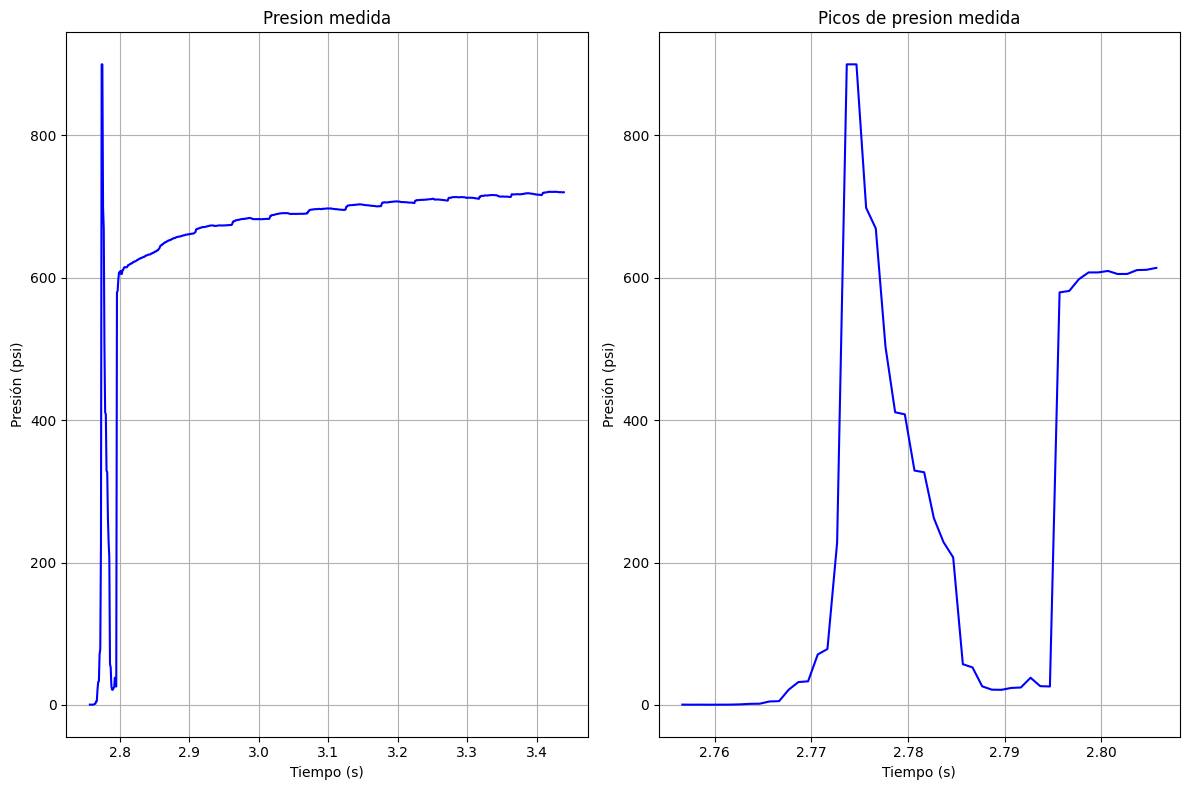

In [8]:
Presion_p = Prueba_presion[' Presión']
t_prueba = np.linspace(0, 0.001*len(Presion_p), len(Presion_p))

t_0 = -2.02
t_1 = 0.666

Pop_max = np.where(Presion_p == max(Presion_p))
t_i = int(Pop_max[0][0] - 17 )
t_f = int(Pop_max[0][0] + t_1*1000)

#print(len(t_prueba), len(Presion_p), t_prueba[Pop_max], Pop_max, Presion_p[Pop_max[0][0]], t_prueba[Pop_max[0][0]], Pop_max[0][0]+ t_0*1000, Presion_p[t_i: t_f])
print(t_prueba[-1]-t_prueba[t_i], np.mean(Presion_p[t_i: t_f]), max(Presion_p[t_i: t_f]) )

fig, ax = plt.subplots(1, 2 , figsize=(12 ,8))


ax[0].plot(t_prueba[t_i : t_f], Presion_p[t_i: t_f], 'b-', markersize = '2')
ax[0].set_title('Presion medida')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Presión (psi)')
ax[0].grid()


ax[1].plot(t_prueba[t_i : t_i+50], Presion_p[t_i: t_i+50], 'b-', markersize = '2')
ax[1].set_title('Picos de presion medida')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Presión (psi)')
ax[1].grid()

plt.tight_layout()
#plt.xlim(left=2.71)

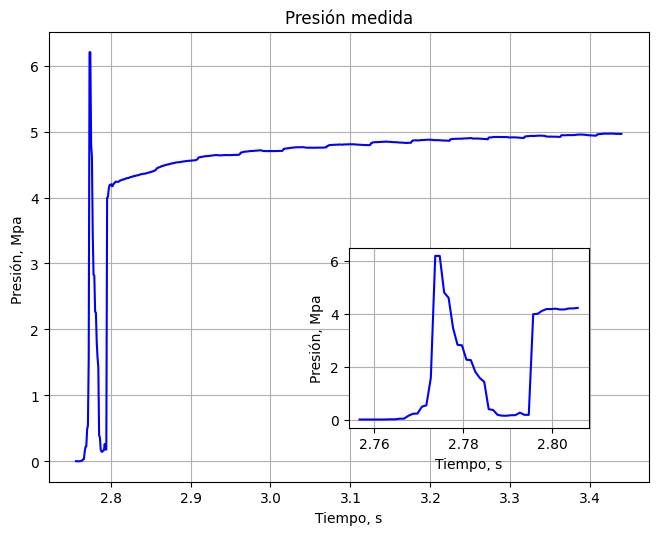

In [44]:


import matplotlib.pyplot as plt
import numpy as np

# Define tus datos de presión y tiempo aquí
Presion_p = Prueba_presion[' Presión']
t_prueba = np.linspace(0, 0.001 * len(Presion_p), len(Presion_p))
t_0 = -2.02
t_1 = 0.666
Pop_max = np.where(Presion_p == max(Presion_p))
t_i = int(Pop_max[0][0] - 17)
t_f = int(Pop_max[0][0] + t_1 * 1000)

# Crear la figura principal
fig = plt.figure(figsize=(12, 9))

# Crear la subfigura (zoom) dentro de la figura principal
left, bottom, width, height = 0.1, 0.1, 0.4*1.25, 0.5
ax_main = fig.add_axes([left, bottom, width, height])

# Graficar en la figura principal
ax_main.plot(t_prueba[t_i: t_f], Presion_p[t_i: t_f]/145.038, 'b-', markersize='2')
ax_main.set_title('Presión medida')
ax_main.set_xlabel('Tiempo, s')
ax_main.set_ylabel('Presión, Mpa ')
ax_main.grid()

# Crear la subfigura (zoom)
left, bottom, width, height = .35, 0.16, 0.2, 0.2
ax_zoom = fig.add_axes([left, bottom, width, height])

# Graficar en la subfigura (zoom)
ax_zoom.plot(t_prueba[t_i: t_i + 50], Presion_p[t_i: t_i + 50]/145.038, 'b-', markersize='2')
#ax_zoom.set_title('Picos de presión medida (Zoom)')
ax_zoom.set_xlabel('Tiempo, s')
ax_zoom.set_ylabel('Presión, Mpa')
ax_zoom.grid()

# Mostrar la figura en pantalla
plt.show()




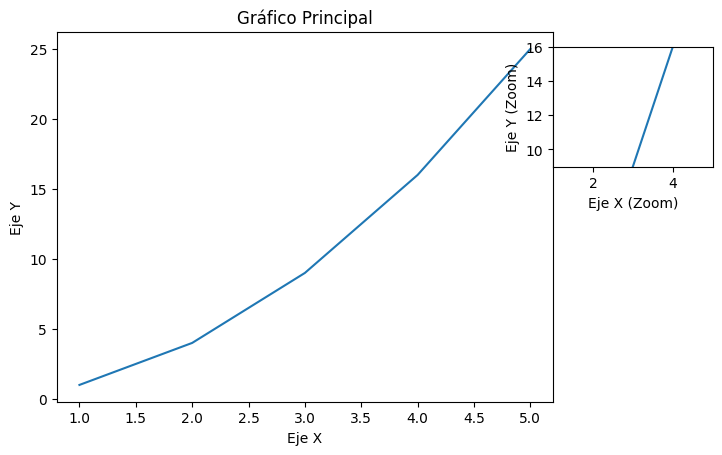

In [10]:
import matplotlib.pyplot as plt

# Crear la figura principal
fig, ax_main = plt.subplots()

# Graficar en la figura principal
ax_main.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
ax_main.set_xlabel('Eje X')
ax_main.set_ylabel('Eje Y')
ax_main.set_title('Gráfico Principal')

# Definir las coordenadas del cuadro de zoom
x_min, x_max, y_min, y_max = 1, 5, 9, 16

# Crear la subfigura (cuadro de zoom)
ax_zoom = fig.add_axes([.9, 0.6, 0.25, 0.25])  # [left, bottom, width, height]

# Graficar en la subfigura
ax_zoom.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
ax_zoom.set_xlim(x_min, x_max)
ax_zoom.set_ylim(y_min, y_max)
ax_zoom.set_xlabel('Eje X (Zoom)')
ax_zoom.set_ylabel('Eje Y (Zoom)')
#ax_zoom.set_title('Zoom de la Gráfica')

# Guardar la figura en un archivo (opcional)
plt.savefig('figura.png')

# Mostrar la figura en pantalla
plt.show()

1.3243231632902122


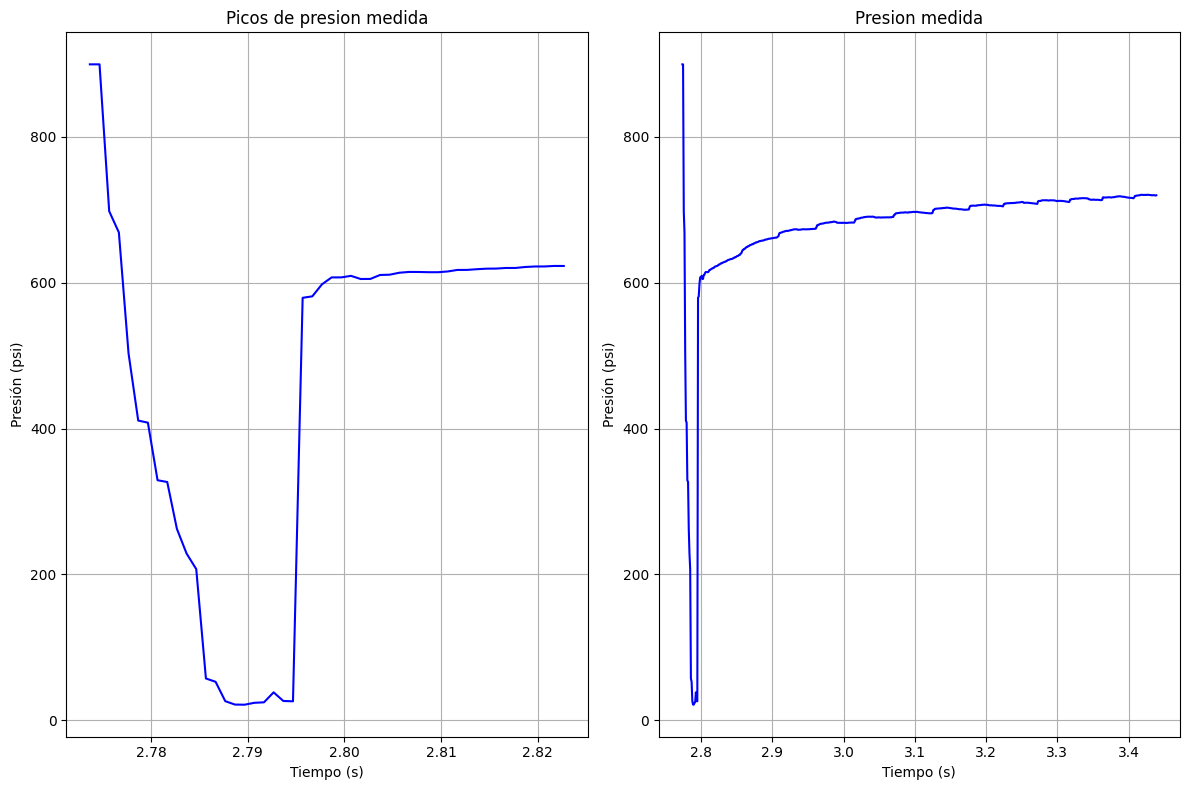

In [11]:
Presion_p = Prueba_presion[' Presión']
t_prueba = np.linspace(0, 0.001*len(Presion_p), len(Presion_p))

t_0 = -2.02
t_1 = 0.666

Pop_max = np.where(Presion_p == max(Presion_p))
t_i = int(Pop_max[0][0] )
t_f = int(Pop_max[0][0] + t_1*1000)

#print(len(t_prueba), len(Presion_p), t_prueba[Pop_max], Pop_max, Presion_p[Pop_max[0][0]], t_prueba[Pop_max[0][0]], Pop_max[0][0]+ t_0*1000, Presion_p[t_i: t_f])
print(t_prueba[-1]-t_prueba[t_i])

fig, ax = plt.subplots(1, 2 , figsize=(12 ,8))
#plt.figure(figsize=(8 ,8))
ax[0].plot(t_prueba[t_i : t_i+50], Presion_p[t_i: t_i+50], 'b-', markersize = '2')
ax[0].set_title('Picos de presion medida')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Presión (psi)')
ax[0].grid()

ax[1].plot(t_prueba[t_i : t_f], Presion_p[t_i: t_f], 'b-', markersize = '2')
ax[1].set_title('Presion medida')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Presión (psi)')
ax[1].grid()
plt.tight_layout()
#plt.xlim(left=2.71)

# Al Can V2 (KNSU) propelente

| Compuesto              | Fórmula Química | Porcentaje |
|------------------------|-----------------|------------|
| Nitrato de potasio     | \( KNO_3 \)     | 62%        |
| Aluminio               | \( Al \)        | 3%         |
| Silicone               | \( SiO_2 \)     | 3%         |
| Azucar de mesa                | \( C_6H_{12}O_6 \) | 32%     |



## Factores de eficiencia

In [18]:
alpha = 15*np.pi/180 # angulo de la divergencia de la tobera 

N_noz = 0.85 # # eficiencia de la tobera
N_com = 0.95 # eficiencia de combustion
N_div = 1/2*(1 + np.cos(alpha)) # factor de corrección por la divergencia
N_po = 0.95 # factor de corrección de la presion de la camara

rho_rat = 0.95


In [13]:
k = 1.141607     # relación de calores especifixos
M = 0.03573117   # kg/mol masa molecular de los gases 
To_T = 1820.426    # K temperatura de combustion teorica
rho_T = 1.8892   # g/cm^3 densidad teorica



To = To_T*N_com # Temperatura "real"
rho = rho_T*rho_rat    # g/cm^3 densidad medida

# Coeficiente y exponente obtenido por Richard Nakka para el propelente KNSU
n = 0.319
a =(8.260/1000)/(10**(6*n)) # Pa, m/s


# r = 275/6 # mm/s
print(C.R/M)

232.69494444206558


# Área de quemado

# Presión

In [14]:
P0 = 800 #psi presion de la camara objetivo
Pa = 14.69594878 # presion atmosferica
Pe = Pa #psi presion de salida de la tobera

## Condiciones del Cohete

In [15]:
m=60 # masa del cohete sin propelente

theta=np.pi/2 #angulo

# Mach
Mt=1
Me=mach(Pe,P0,k)
print(Me)

3.010761166043676


## Estudio de la eficiencia de una tobera con subexpandida respecto a una ideal para citlaltonac


In [41]:
k = 1.141607     # relación de calores especifixos
M = 0.03573117   # kg/mol masa molecular de los gases 
To_T = 1820.426    # K temperatura de combustion teorica
rho_T = 1.8892   # g/cm^3 densidad teorica
Pa = 14.69 

In [42]:
P0 = 800 #psi, presion de la camara objetivo
Pa = 14.69594878 # psi, presion atmosferica
Pe = 2.3761*Pa #psi, presion de salida de la tobera

Mt = 1
Me = mach(Pe,P0,k)

Dc = 102.20 #mm Diametro de la camara 
Dt = (24/16)*25.4 # mm, de pulgadas a mm [(in)*(mm/in)]


Ac = np.pi*(Dc/2)**2 # mm**2 # área de la camara
At = np.pi*(Dt/2)**2 # mm**2 # área de la garganta
AcAt = Ac/At

AeAt = RatArea(Me, Mt, k)
Ae = At*AeAt

eta_noz = 0.85
Cf_1 = eta_noz*Cf_(Pe,P0, Pa, At, Ae, k)

print(Cf_1)

1.3267266342346447


In [43]:
P0 = 928 #psi, presion de la camara objetivo
Pa = 14.69594878 # psi, presion atmosferica
Pe = Pa #psi, presion de salida de la tobera

Mt = 1
Me = mach(Pe,P0,k)

Dc = 102.20 #mm Diametro de la camara 
Dt = (24/16)*25.4 # mm, de pulgadas a mm [(in)*(mm/in)]


Ac = np.pi*(Dc/2)**2 # mm**2 # área de la camara
At = np.pi*(Dt/2)**2 # mm**2 # área de la garganta
AcAt = Ac/At

AeAt = RatArea(Me, Mt, k)
Ae = At*AeAt

Cf_2 = eta_noz*Cf_(Pe,P0, Pa, At, Ae, k)

print(Cf_2)

1.3784043963258887


In [27]:
Cf_1/Cf_2

0.9868736657423679

In [17]:
Dc=102.20 #mm Diametro de la camara 
Ac=C.pi*(Dc/2)**2 #mm**2 # área de la camara


AtAc_l=[1/5.5] #RatArea(Mt,Mc,k)
At_l=[Ac*AtAc_l[0]]

At = At_l[-1]
Dt=diametro(At)


AeAt = RatArea(Me, Mt, k)
Ae=At*AeAt

De=diametro(Ae)

# Calculos teoricos
Cf_t = Cf_(Pe,P0, Pa, At, Ae, k)
Isp_t = Isp_(k,Pe,P0,To,M)


Cf = Cf_t*N_noz
Isp = Isp_t*N_noz*N_com*N_div*N_po # s

F_thrust = thrust(Cf,At,P0)
Ve = ex_vel(C.R/M, To, k)*Cf # Velocidad de salida de los gases de la tobera
dm = F_thrust/Ve

mp0 = m*(np.exp(np.sqrt(2*C.g*3000)/Ve)-1) # masa minima
print(mp0, Ve, np.sqrt(2*C.g*3000))

11.774539288807713 1353.7351895427316 242.56937152080843


Este analisis para obtener la masa del propelente no incluye la fuerza de fricción, por lo que se necesita resolver numéricamente las ecuaciones de movimiento como se hace posteriormente.
Para poder obtener la masa total incluyendo el propelente se puede se puede resolver con una serie geometrica de la forma
$$
\frac{M}{m}=\Sigma_{n=0}^\infty (MR)^n=\frac{1}{1-MR} ,    |MR|<1
$$
Para poder obtener un MR razonable se puede hacer un promedio de la funcion de mp/m=MR de la forma
$$
 MR=\langle \frac{m_p}{m} \rangle=\frac{1}{I_{sp}}\sqrt{\frac{2hF}{gsen\theta}} \frac{1}{b-a}\int_a^b\frac{dm}{\sqrt{Fsen\theta-mg}} 
$$
O aun mejor se puede utilizar las iteraciónes para tener un resultado mas adecuado como se muestra a continuación.

In [18]:
# Con este codigo se pretende obtener un primer valor cercano para así poder obtener la masa que se necesita con el método de las ecs diferenciales.

# Integral de mp/m
from scipy import integrate
h=3000 # altura deseada
a_1, b_1 = 40, 60
c =(1/Isp)*np.sqrt(2*h*F_thrust/(np.sin(theta)*C.g))
K = lambda m: c*(1/np.sqrt(F_thrust*np.sin(theta)-C.g*m))   

MR=1/(b_1-a_1)*(integrate.quadrature(K, a_1, b_1)[0]) # relacion de masa del propelente y el cohete

# Método iterativo 
i = 0
m_p0 = [0]
M_tot0 = [m]
error=1
while error > 10**-6:
    
    m_p0.append(M_tot0[i]*K(M_tot0[i]))
    M_tot0.append(m+m_p0[i+1])
    error = M_tot0[i+1]-M_tot0[i]
    #print(error, M_tot[-1])
    i+=1

# Mtot = m*(1/(1-MR)) # masa total con calculo de promedio

# h1 = altura(Mtot ,Mtot-m, F, Isp, np.pi/2) #altura alcanzada
h2 = altura(M_tot0[-1] ,m_p0[-1], F_thrust, Isp, np.pi/2) # Altura con metodo iterativo
t = Isp*(M_tot0[-1]-m)*C.g/F_thrust # tiempo de empuje


print( t, M_tot0[-1], m_p0[-1], h2, Isp) # mm

1.7031894946237067 75.85892398813708 15.858923988137082 2999.9999506031572 122.4608827376444


## Dimensiones de la tobera

In [19]:

ApAt=2
Dp = np.sqrt(ApAt)*Dt #Diametro del port

# Área de quemado
V0 = mp0*1000/rho # cm^3 Volumen con densidad experiemental del grano

Va0 = (V0)/(1-ApAt*At*4/(np.pi*Dc**2)) # cm^3

L0 = Va0*10**3/Ac # mm  Longitud del grano con densidad experimentale

p0 = [4, Dc-.6, Dp, L0/4] #  N, D, d, L, At, = p
Ab0 = Ab_(0,1,1, p0)

Kn_max= Kn_pol(P0)
Kn = Kn_(At, Ab0[-1])

At2 = max(Ab0[-1])/Kn_max






print(Dc,Dt,De, Ac, At, Ae, AeAt)
#print(Dc, Dt, De, Dp)
#print(diametro(At), diametro(At2), L0, Kn_max, Kn)

102.2 43.578226423086775 126.39127261608463 8203.358152980203 1491.5196641782188 12546.542290151863 8.41191879093637


# Determinantes del rendimiento

In [20]:


# Calculos con factores de eficiencia
Cf = Cf_t*N_noz
F = thrust(Cf,At,P0)
Isp = Isp_t*N_noz*N_com*N_div*N_po # s

Ve = ex_vel(C.R/M, To, k)*Cf # Velocidad de salida de los gases de la tobera
dm = F/Ve # flujo masico

print(Cf, F, Isp, dm, Ve, ex_vel(C.R/M, To, k))

1.359223498817372 11182.23999918248 122.4608827376444 8.260286122103134 1353.7351895427316 995.962173049969


892.6866170512181 802.3373487782477 1.4124408100186616


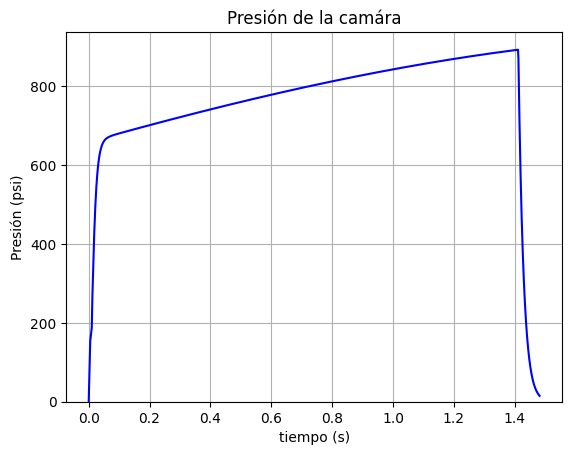

In [21]:
# Superficies de quemado
Bs = [0, 1, 1, 4]

Datos = 1000
t_web0 = np.array([(Dc-0.6-Dp)/2])
Xinc = np.linspace(0, t_web0[0]/(1+Bs[0]*Bs[1]), Datos)
t_web = np.append(t_web0, t_web0[0]-Xinc)

D = Dc-0.6 - Bs[0]*2*Xinc
d = Dp + Bs[1]*2*Xinc
L = L0 - Bs[2]*Bs[3]*2*Xinc

Vc = np.pi*(Dc/2)**2*L0/(1000**3) # m^3
V_G = 1/4*np.pi*(D**2-d**2)*L/(1000**3) # m^3
V_F = Vc - V_G

P_a = 0.101325

Po_abs1 = [] # En Pa
Po_abs2 = [P_a] # En Mpa
m_grain = rho*1000*V_G # kg
m_gen = [0]
m_noz = [0]
m_sto = [0]
mass_sto = [0]
rho_prod = []
t1 = [0]
a1 = 8.260
#r = lambda P: a1*P**n
R = [a1*(Po_abs2[0]**n)]

for i in range(len(Xinc)-1):
    rho_prod.append(mass_sto[i]/V_F[i])


    Po_abs1.append(rho_prod[i]*C.R/M*To+P_a*10**6)
    Po_abs2.append(Po_abs1[i]/(10**6))
    R.append(a1*(Po_abs2[i])**n)
    t1.append(Xinc[1]/R[i+1] + t1[i]) #2
    m_gen.append((m_grain[i]-m_grain[i+1])/(t1[i+1]-t1[i]))
    
    # print(mdot(At/(10**6),(Po_abs2[i+1]-P_a)*10**6, k,To,C.R/M), Po_abs2[i+1]-P_a, Po_abs1[i])
    if m_gen[i+1] < mdot(At/(10**6),(Po_abs2[i+1]-P_a)*10**6, k,To,C.R/M):
        if Po_abs2[i+1] > 0:
            m_noz.append( mdot(At/(10**6),(Po_abs2[i+1]-P_a)*10**6, k,To,C.R/M))
        else :
            m_noz.append(0)
    else :
        m_noz.append(mdot(At/(10**6),(Po_abs2[i+1]-P_a)*10**6, k,To,C.R/M))
    
    m_sto.append(m_gen[i+1]-m_noz[i+1])
    

    #print(m_sto, t1, mass_sto, i)
    if m_sto[i+1]*(t1[i+1]-t1[i]) + mass_sto[i] < 0 :
        mass_sto.append(0)
    else :
        mass_sto.append(m_sto[i+1]*(t1[i+1]-t1[i]) + mass_sto[i])

Vc = Va0*10**-6
A_t = At*10**-6
A_e = Ae*10**-6

Po_gage =  np.array(Po_abs2) - P_a
Po_max = max(Po_abs2) - P_a
Po_final = (0.02/100)*Po_max + P_a

t_final = -np.log(Po_final/(Po_abs1[-1]*10**-6))*((Vc)*ex_vel(C.R/M, To, k))/(C.R/M*To*(A_t))
t2 = np.linspace(t1[-1], t1[-1]+ t_final, 100)

t_thrust = np.append(np.array(t1), t2[1:])

A1 = (C.R/M)*To*(A_t)*(t2[1:]-t1[-1])
A2 = (Vc)*ex_vel(C.R/M, To, k)

Pc = np.array(Po_abs2[-1]*(np.exp(-A1/A2)))

Po_gage = np.array(Po_abs1)*10**-6 - P_a
Presion_camara = np.append(Po_gage, Pc)


print( Po_max*1000000/6895, np.mean(Po_abs2)*1000000/6895, t1[-1])


#print(Po_final, Po_abs1[-1]*10**-6,Pc[-1], t2[-1], (C.R/M)*To*(At/10**6)/A2, At, t2[1]-t2[0])
plt.plot(t_thrust[0:-1], Presion_camara*1000000/6895, 'b-')
plt.ylim(bottom=0)
plt.ylabel('Presión (psi)')
plt.xlabel('tiempo (s)')
plt.title('Presión de la camára')
plt.grid()
plt.show()


# print(Xinc[1], R[1], t1[-1], rho_prod[1], mass_sto[1], m_sto[1], m_noz[1],m_gen[1], m_grain[0], m_grain[1], Pc[-1], t2[0]==t1[-1], t2[1]-t2[0], t_final) # 1,1,1,0,0,0,1


In [22]:
print(len(Presion_camara), len(t_thrust))

1098 1099


12828.739469450604 10452.721965847377 15906.030291960164 Isp = 137.75177588686975


C:\Users\leo_1\AppData\Local\Temp\ipykernel_24964\2217227967.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)
C:\Users\leo_1\AppData\Local\Temp\ipykernel_24964\2217227967.py:18: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)
C:\Users\leo_1\AppData\Local\Temp\ipykernel_24964\2217227967.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)


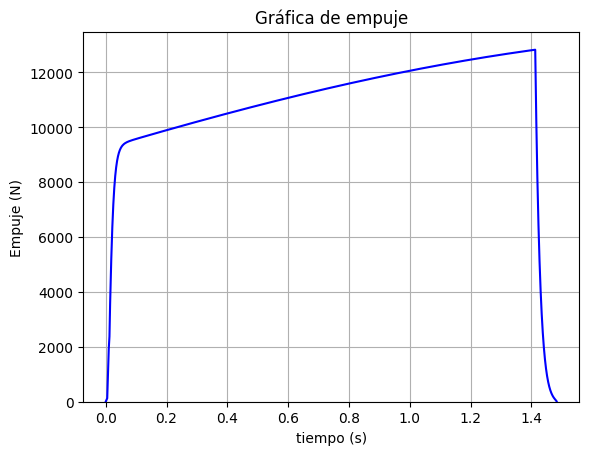

In [23]:
F = [0]
C_f = [N_noz]
P_e =[]
Ae_At = [1]
I_t = [0]
abc = np.append(np.array(Po_abs1)*10**-6, Pc)
Po_thrust = np.append(abc, 0)
P = lambda Po: Po*(1+(k-1)/2*Me**2)**(-k/(k-1))
for i in range(len(t_thrust)-1):

    if P(Po_thrust[i]*10**6) < P_a*10**6:
        P_e.append(P_a*10**6)
    else :
        P_e.append(P(Po_thrust[i]*10**6))
    
    C_f.append(N_noz*Cf_(P_e[i], Po_thrust[i+1]*10**6, P_a*10**6, A_t, A_e, k))

    F.append(C_f[i]*Po_thrust[i]*10**6*A_t)

    I_t.append((F[i+1] + F[i])/2*(t_thrust[i+1]-t_thrust[i]))
#print(Po_thrust)
#print(C_f) # hay un problema con el inicio de la gráfica
print(max(F), np.mean(F), sum(I_t), f'Isp = {sum(I_t)/(C.g*mp0)}')
plt.plot(t_thrust, F, 'b-')
plt.ylim(bottom=0)
plt.ylabel('Empuje (N)')
plt.xlabel('tiempo (s)')
plt.title('Gráfica de empuje')
plt.grid()
plt.show()





(1099,)


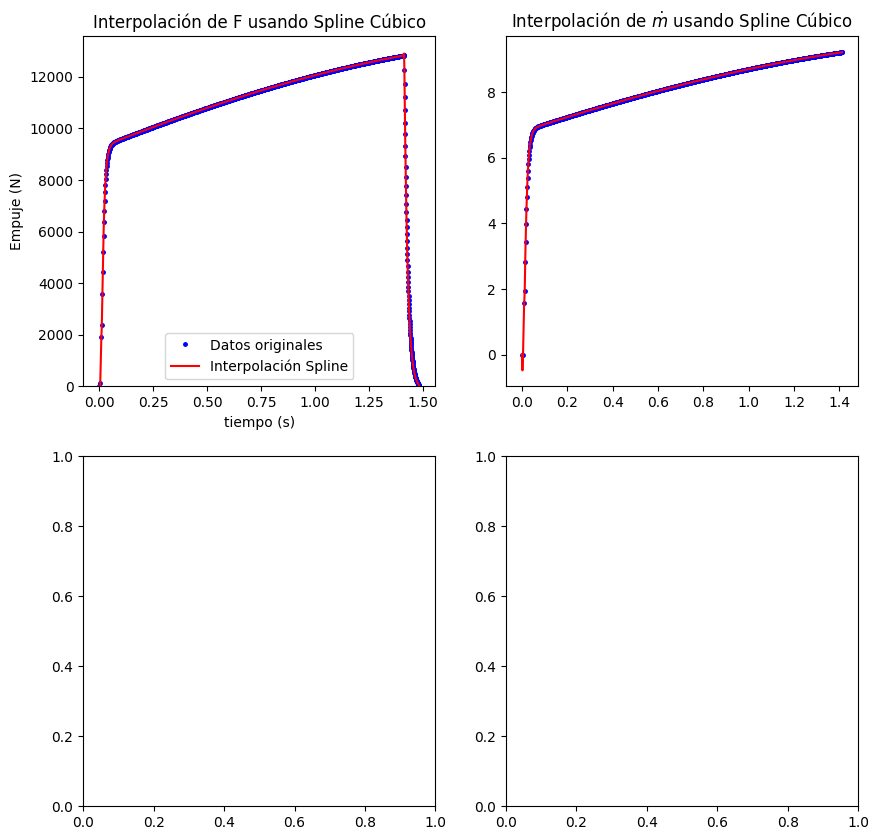

In [24]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Asumiendo que t_thrust y F ya están definidos:
# t_thrust = [...]
# F = [...]

#print(np.squeeze(t1))
print(np.shape(np.squeeze(t_thrust)))
# Crear una función spline para F en función del tiempo t_thrust
F_spline = CubicSpline(t_thrust, F)
m_noz_spline = CubicSpline(t1, m_noz)

t1_new = np.linspace(t1[0], t1[-1], 1000)
m_noz_new = m_noz_spline(t1_new)


# Opcional: Graficar para verificar la interpolación
t_new = np.linspace(min(t_thrust), max(t_thrust), 1000)
F_new = F_spline(t_new)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0,0].plot(t_thrust, F, 'bo', markersize='2.5', label='Datos originales')
ax[0,0].plot(t_new, F_new, 'r-', label='Interpolación Spline')
ax[0,0].legend()
ax[0,0].set_xlabel('tiempo (s)')
ax[0,0].set_ylabel('Empuje (N)')
ax[0,0].set_title('Interpolación de F usando Spline Cúbico')
ax[0,0].set_ylim(bottom=0)

ax[0,1].plot(t1, m_noz, 'bo', markersize='2.5', label='Datos originales' )
ax[0,1].plot(t1_new, m_noz_new, 'r-')
ax[0,1].set_title(r'Interpolación de $\dot{m}$ usando Spline Cúbico')

plt.show()


# Trayectoria y altura

01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho

def F(t, t_thrust):
    return np.piecewise(t, [t < t_thrust, t >= t_thrust], [F_spline(t), 0])

def dm(t, t_b):
    return np.piecewise(t, [t < t_b, t >= t_b], [m_noz_spline(t), 0])



# Sistema de ecuaciones
def sis(CI, t, p):
    m, Cd, A, t_thrust, t_b, theta, fase = p
    x, u, y, v = CI

    F_t = F(t, t_thrust)
    dm_t = dm(t, t_b)
    
    dxdt = u
    dudt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.sin(theta) - C.g
    
    return [dxdt, dudt, dydt, dvdt]


# Parámetros
# p = [m, Cd, A, t_thrust, t_b, theta, fase]






h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)


# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while h[i] < h0:

    t_thr = Isp*C.g*m_p[i]/F_thrust # tiempo de empuje

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, t_thr, 1000)
    p1 = [M_tot[i], Cd , A, t_thr, t1[-1], theta, 1]
    Sol_1 = odeint(sis, CI1, t1, args=(p1, ))

    # Calculos fase 2
    

    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(t_thr,  50, 1000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, t_thr, t1[-1], theta, 0]
    Sol_2 = odeint(sis, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.005)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])
    print(h[i])
    i+=1
    

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('x [m]')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

 # el extra de 3.45 es para que se cumpla que al tiempo tf la masa total sea igual a la masa sin propelente solo que  se tiene que 
#justificar de alguna otra manera, si se agragamos ese extra a las ecuaciones diferenciales, nos quita 400 gramos de la masa del propelente.

print(t_thr, max(h), m_p[-1], Fd_max, It, F_thrust/m) 

plt.tight_layout()
plt.show()

In [25]:

# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho

def F_(t, t_thrust):
    return np.piecewise(t, [t < t_thrust, t >= t_thrust], [F_spline(t), 0])

def dm_(t, t_b):
    return np.piecewise(t, [t < t_b, t >= t_b], [m_noz_spline(t), 0])



# Sistema de ecuaciones
def sis(CI, t, p):
    m, Cd, A, t_thrust, t_b, theta, fase = p
    x, u, y, v = CI

    F_t = F_(t, t_thrust)
    dm_t = dm_(t, t_b)
    
    dxdt = u
    dudt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.sin(theta) - C.g
    
    return [dxdt, dudt, dydt, dvdt]


# Parámetros
# p = [m, Cd, A, t_thrust, t_b, theta, fase]






h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)


# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while h[i] < h0:

    t_thr = Isp*C.g*m_p[i]/F_thrust # tiempo de empuje

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, t_thr, 1000)
    p1 = [M_tot[i], Cd , A, t_thr, t1[-1], theta, 1]
    Sol_1 = odeint(sis, CI1, t1, args=(p1, ))

    # Calculos fase 2
    

    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(t_thr,  50, 1000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, t_thr, t1[-1], theta, 0]
    Sol_2 = odeint(sis, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.05)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])
    print(h[i])
    i+=1
    

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('x [m]')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

 # el extra de 3.45 es para que se cumpla que al tiempo tf la masa total sea igual a la masa sin propelente solo que  se tiene que 
#justificar de alguna otra manera, si se agragamos ese extra a las ecuaciones diferenciales, nos quita 400 gramos de la masa del propelente.

print(t_thr, max(h), m_p[-1], Fd_max, It, F_thrust/m) 

plt.tight_layout()
plt.show()


0
1889.83256458008
1905.631458398294
1921.485782766761
1937.3936285942389
1953.3518488991087
1969.367760080253
1985.4322162648368
2001.5515667747093
2017.7228069180212
2033.9443271047585
2050.2208837741673
2066.545049244577
2082.924774717705
2099.3529493878273
2115.8328120801425
2132.364251301538
2148.9432150999655
2165.57711765394
2182.2569011921473
2198.989697919975
2215.7702304885343
2232.600052480288
2249.4808131011655
2266.4071196317923
2283.3866907795787
2300.4103674512094
2317.486217104984
2334.610358781072
2351.1107832727125
2362.641811187388
2369.8358947727156
2373.9295661071487
2375.815797366745
2376.1353250539782
2375.3467596679184
2373.779481766489
2371.662831957379
2369.1644564801963
2366.4041134765616
2363.4576845745764
2360.3796602231946
2357.177069841982
2353.087418120011
2345.086698638285
2327.5294679708313
2292.2539760188524
2228.8288699544332
2125.1035009849443
1968.2900784843519
1746.9581429750938
1454.7738398805923
1097.0920656087258
702.888604768674


c:\Users\leo_1\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


344.79624946078565
166.1198703635915
165.67210741293488
165.54495386537536
165.41849959935817
165.29370625856814
165.16487456059627
165.04167240356827
164.91653692303873
164.78869086395434
164.6649529787393
164.5412726893751
164.4159175386499
164.28928641585793
164.16498808904487
164.04235977386443
163.91896395308547
163.79510091984773
163.6709858171614
163.5468240613947
163.42278839164504
163.29899563967808
163.17557186757267
163.052555087646
162.92996261049353
162.80777347138232
162.68594702557624
162.5643849622571
162.44295231806672
162.32150114886136
162.1998440418304
162.0777231810452
161.95488358819108
161.8320300310751
161.71352390793632
161.59394402151926
161.47288484463306
161.34994968301592
161.23055659176876
161.11228700290042
160.99127415256817
160.8688889776231
160.7525785058887
160.63239090959092
160.5108298899851
160.39478219951752
160.27348547314827
160.1558919822274
160.03762500866773
159.91705940648544
159.8012814266535
159.67922453143507
159.56516066139253
159.442934

KeyboardInterrupt: 

90.74767369808671 1.5702521091886121 0.03145874441077082 1949.4692323080478


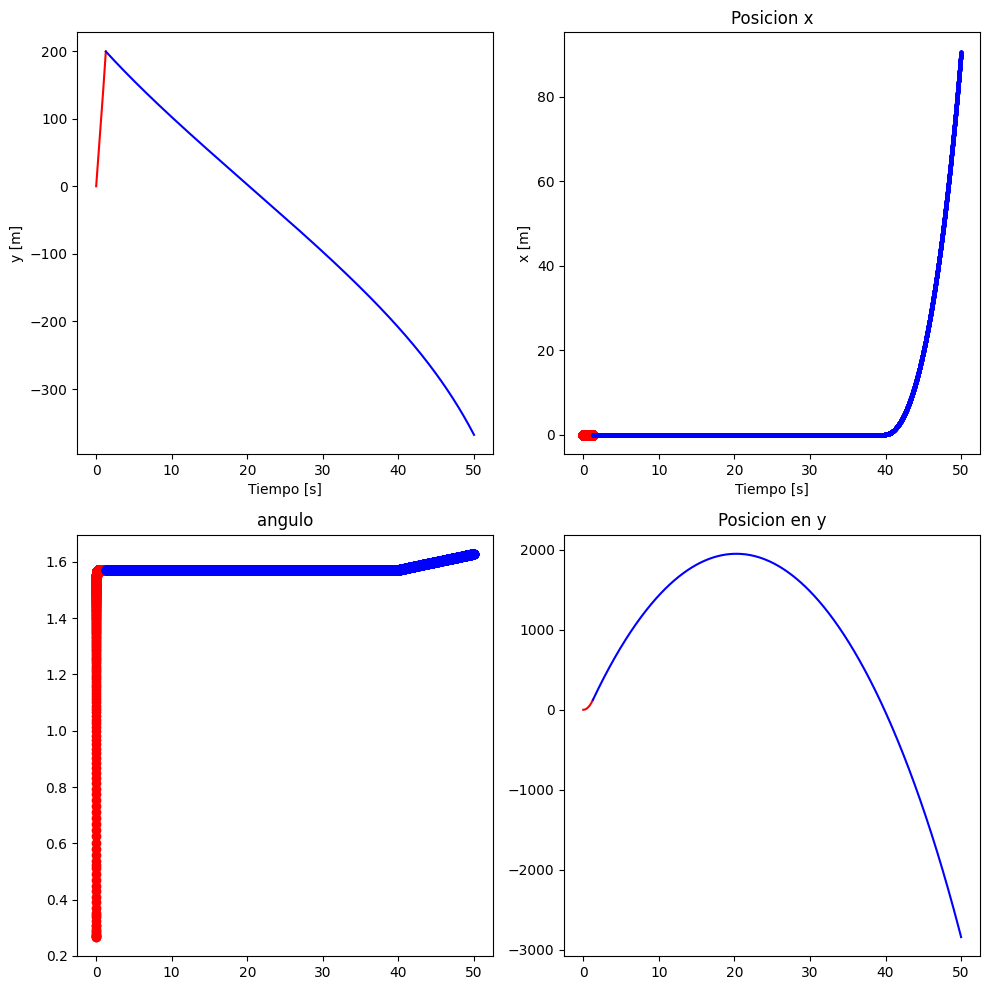

In [ ]:
# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

from scipy.integrate import solve_ivp

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho



# Sistema de ecuaciones
def sis(t, CI, p):
    m, Cd, A, F_t, dm_t, fase = p
    u, theta, x, y = CI

    
    dudt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2)) - C.g*np.sin(theta)

    dvdt = -(C.g/u - u/np.sqrt(x**2 + y**2))*np.cos(theta)
    
    
    dxdt = u*np.cos(theta)
    dydt = u*np.sin(theta)
    
    return [dudt, dvdt, dxdt, dydt]


# Parámetros
# p = [m, Cd, A, t_thrust, t_b, theta, fase]

#theta_spline = CubicSpline(t2, Sol_2[:,2])
#Vel_spline = CubicSpline(t2, Sol_2[:,1])

#t2_new = np.linspace(t2[0], t2[-1], 1000)

#N = lambda t : theta_spline(t)*Vel_spline(t)


theta = np.pi/6 

h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)


# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while i < 1:

    t_thr = Isp*C.g*m_p[i]/F_thrust # tiempo de empuje

    # Calculos fase 1
    CI1 = [0.001, theta, 0.001, 0.001] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, t_thr, 10000)
    p1 = [M_tot[i], Cd , A, F_thrust, dm, 1]
    Sol_1 = solve_ivp(sis, [0, t_thr] , CI1, args=(p1, ), t_eval=t1)

    # Calculos fase 2
    

    CI2 = [Sol_1.y[0,-1], Sol_1.y[1, -1], Sol_1.y[2, -1], Sol_1.y[3, -1]] # Condiciones iniciales
    t2 = np.linspace(t_thr,  50, 10000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, 0, 0, 0]
    Sol_2 = solve_ivp(sis, [t_thr, 50] , CI2, args=(p2, ), t_eval=t2)



    #h.append(max(Sol_2[:,1]*np.cos(Sol_2[:,2])))

    #if h[i+1] < h0:
        #M_tot.append(M_tot[i] + 0.005)
        #m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])
    # print(h[i+1])
    i+=1
    

#Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax[0,0].plot(Sol_1.t, Sol_1.y[0], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax[0,1].plot(Sol_1.t, Sol_1.y[2], 'ro') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax[0,0].plot(Sol_2.t, Sol_2.y[0], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax[0,1].plot(Sol_2.t, Sol_2.y[2], 'bo', markersize='2') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x

ax[0,1].set_title('Posicion x')


ax[0,0].set_xlabel('Tiempo [s]')
ax[0,0].set_ylabel('y [m]')
#ax1.set_ylim(bottom=0)

ax[0,1].set_xlabel('Tiempo [s]')
ax[0,1].set_ylabel('x [m]')
#ax2.set_ylim(bottom=0)


ax[1,0].plot(Sol_1.t, Sol_1.y[1], 'ro')
ax[1,0].plot(Sol_2.t, Sol_2.y[1], 'bo')
ax[1,0].set_title('angulo')

ax[1,1].plot(Sol_1.t,Sol_1.y[3] , 'r-')
ax[1,1].plot(Sol_2.t,Sol_2.y[3] , 'b-')
ax[1,1].set_title('Posicion en y')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

#print( Sol_2.y[2])
print(max(Sol_2.y[2]), min(Sol_2.y[1]), Sol_2.y[2, 0], max(Sol_2.y[3]))




#print(t_thr, max(h), m_p[-1], Fd_max, It, F_thrust/m) 

plt.tight_layout()
plt.show()

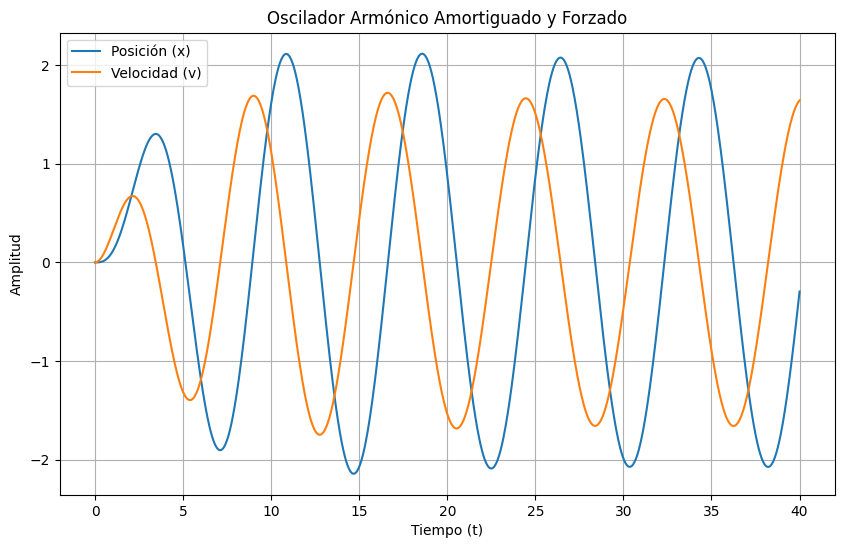

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Definir el sistema de ecuaciones diferenciales
def damped_driven_oscillator(t, z, omega0, zeta, F0, omega):
    x, v = z
    dxdt = v
    dvdt = -2 * zeta * omega0 * v - omega0 ** 2 * x + F0 * np.sin(omega * t)
    return [dxdt, dvdt]

# Parámetros del sistema
omega0 = 1.0   # Frecuencia natural
zeta = 0.2     # Tasa de amortiguamiento
F0 = 1.0       # Amplitud de la fuerza externa
omega = 0.8    # Frecuencia de la fuerza externa

# Condiciones iniciales
x0 = 0.0
v0 = 0.0
initial_conditions = [x0, v0]

# Definir el rango de tiempo
t_span = (0, 40)
t_eval = np.linspace(*t_span, 1000)

# Resolver el sistema de ecuaciones diferenciales
solution = solve_ivp(damped_driven_oscillator, t_span, initial_conditions, args=(omega0, zeta, F0, omega), t_eval=t_eval)

# Extraer los resultados
t = solution.t
x, v = solution.y

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(t, x, label='Posición (x)')
plt.plot(t, v, label='Velocidad (v)')
plt.xlabel('Tiempo (t)')
plt.ylabel('Amplitud')
plt.title('Oscilador Armónico Amortiguado y Forzado')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente


## copia de seguridad
from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho



# Sistema de ecuaciones
def sis(CI, t, p):
    m, Cd, A, F_t, dm_t, theta, fase = p
    x, u, y, v = CI

    
    dxdt = u
    dudt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.sin(theta) - C.g
    
    return [dxdt, dudt, dydt, dvdt]


# Parámetros
# p = [m, Cd, A, t_thrust, t_b, theta, fase]






h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)


# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while h[i] < h0:

    t_thr = Isp*C.g*m_p[i]/F_thrust # tiempo de empuje

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, t_thr, 1000)
    p1 = [M_tot[i], Cd , A, F_thrust, dm, theta, 1]
    Sol_1 = odeint(sis, CI1, t1, args=(p1, ))

    # Calculos fase 2
    

    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(t_thr,  50, 1000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, 0, 0, theta, 0]
    Sol_2 = odeint(sis, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.005)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])
    print(h[i])
    i+=1
    

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('x [m]')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

 # el extra de 3.45 es para que se cumpla que al tiempo tf la masa total sea igual a la masa sin propelente solo que  se tiene que 
#justificar de alguna otra manera, si se agragamos ese extra a las ecuaciones diferenciales, nos quita 400 gramos de la masa del propelente.

print(t_thr, max(h), m_p[-1], Fd_max, It, F_thrust/m) 

plt.tight_layout()
plt.show()

In [ ]:
# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho

# Sistema de ecuaciones
def f(CI, t, p):
    m, Cd, A, F, theta, fase = p
    x, u, y, v, = CI

    dxdt = u
    dudt =  (1/(m-fase*(dm)*t))*(fase*F - 1/2*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt =  (1/(m-fase*(dm)*t))*(fase*F - 1/2*densidad_aire(y)*A*Cd*(u**2 + v**2)*np.sin(theta)) - C.g
    return [dxdt, dudt, dydt, dvdt]

h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)

# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while h[i] < h0:

    tf = Isp*(M_tot[-1]-m)*C.g/F_thrust

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, tf, 1000)
    p1 = [M_tot[i], Cd , A, F_thrust, theta, 1]
    Sol_1 = odeint(f, CI1, t1, args=(p1, ))

    # Calculos fase 2
    

    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(tf,  50, 1000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, 0, theta, 0]
    Sol_2 = odeint(f, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.005)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])

    i+=1

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('x [m]')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

L3 = M_tot[-1]-(dm)*tf # el extra de 3.45 es para que se cumpla que al tiempo tf la masa total sea igual a la masa sin propelente solo que  se tiene que 
#justificar de alguna otra manera, si se agragamos ese extra a las ecuaciones diferenciales, nos quita 400 gramos de la masa del propelente.

print(tf, max(h), m_p[-1], Fd_max, It, L3, F_thrust/m) 

plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for *: 'int' and 'function'

In [ ]:
# Nueva manera de como obtener la masa del propelente aproximada, se necesita mas información pero realmente es un valor cercano a lo que se puede esperar
# con mi método

v1 = 1.2*np.sqrt(2*C.g*3000)
m1 = m*(np.exp(v1/(Isp*C.g))-1) 
print(m1)

16.456800582610498


## Volumen propelente
Para obetner un buen flujo de los gases de la camara con una relación $L/D=6$
$$
\frac{A_p}{A_t}=\frac{\pi D^2(1-V_1)}{4A_t}
$$
Donde D es el diametro del propelente y V1 es la relación de propelente y volumen de la camara
$$
V_1=\frac{V_p}{V_a}
$$
Donde $V_p$ es el volumen del propelente y $V_a$ es el volumen valido de la camara. Despejando para $V_a$
$$
V_a=\frac{V_p}{1-\frac{A_p}{A_t}A_t\frac{4}{\pi D^2}}
$$

In [ ]:
# Longitud de la camara 

V = m_p[-1]*1000/rho # cm^3 Volumen con densidad experiemental
V_t = m_p[-1]*1000/rho_T # cm^3 Volumen con densidad teorica
L = V_t*1000/Ac # mm  Longitud del grano solido sin huecos
# print(MR, K(50), Mtot, h1)

ApAt=1.9


Dp = np.sqrt(ApAt)*Dt #Diametro del port

Va1 = (V)/(1-ApAt*At*4/(np.pi*Dc**2)) # cm^3
L = Va1*10**3/Ac # mm  Longitud del grano con densidad experimentale

Va2 = (V_t)/(1-ApAt*At*4/(np.pi*Dc**2)) # cm^3
L_t = Va2*10**3/Ac # mm L_t=L_g

# L_g= V_t*10**3/(Ac-ApAt*At) ## mm longitud del grano con densidad teorica
Wf = (Dc-Dp)/Dc

print(Wf, V/Va1,L, L/Dc , L_t, L_t/Dc, Dp, Dt)

0.41224618635474136 0.6545454545454545 1416.9671795828547 13.946527358098963 1346.1188206037118 13.249200990194014 59.71578746635827 43.32238556346004


In [ ]:

p = [4, Dc-.6, Dp, L/4] #  N, D, d, L, At, = p
Ab = Ab_(0,1,1, p)

Kn = Kn_(At, Ab[3])

Kn_max = Kn_pol(P0)

At2 = max(Ab[3])/Kn_max

At_l.append(At2)
AtAc_l.append(At2/Ac)

P_0 = presion(Kn_max, a, rho*1000, n, k, C.R/M, To*N_com)/6895.76 # psi

AeAt2 = RatArea(mach(Pe,P_0,k), 1, k)

print(Kn, P_0, Kn_max, diametro(At2), diametro(AeAt2*At), diametro(At_l[-1]))

[208.61859158397212, 242.67056068034918, 269.4648412829856] 909.9336390735468 242.7022594294697 45.64849961185772 132.13069167538416 45.64849961185772


In [ ]:
print(8.260*0.10128398**n)

3.9787582246731867


## Datos obtenidos
Aquí se muestra en una tabla todos los datos importantes que se calcularon para la misión relacionados con motor (Por completar)